# Proyecto práctico - Acrobot


---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [1]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount = '/content/drive'
drive_root = mount + "/MyDrive/99_MasterIA/08_AprendizajePorRefuerzo/proyecto_programacion/modelo"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [2]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['data-structures-and-logic-python.ipynb', 'reinforcement-learning-dqn-acrobot.ipynb']


---
### 1.4. Instalar librerías necesarias

In [ ]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.12.0
  %pip install protobuf==3.20.*
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será [Acrobot-v1](https://www.gymlibrary.dev/environments/classic_control/acrobot/) y el algoritmo que usaremos será _DQN_.
- Se proporciona una solución base ("BASELINE"), que servirá como punto de partida para los experimentos.

Este proyecto práctico consta de tres partes:

1.   Mejorar la solución base basada en e-greedy DQN: hyper-parametros, arquitectura, etc.
2.   Investigar y detallar (a nivel teórico) las diferencias de este agente con: **Bolzman Policy**, **Double DQN**, **Dueling DQN**.
3.   Comparar, empleando keras-rl, el rendimiento (recomensa total, velocidad de convergencia, etc.) con estos métodos más avanzados.
4.   Justificar los hyper-parámetros empleados para cada configuración. Como afecta a la performance, por ejemplo, ¿un cámbio en el scheduler de épsilon? ¿Cómo afecta aumentar/disminuír la actualización de la target network?¿Cómo afecta aumentar/disminuír el tamaño de la memoria?
5. Conclusiones y discusion.

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada.

IMPORTANTE:

* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [ ]:
# Imports generales
from __future__ import division
from PIL import Image
import numpy as np

# Imports de entorno
import gym

# Imports de deep learning
import tensorflow as tf

# Imports de keras-rl
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy, BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger # Para poder comparar curvas de aprendizaje
from tensorflow.keras.optimizers.legacy import Adam, SGD

#### Configuración entorno

In [ ]:
# Configuración enviroment
env_name = 'Acrobot-v1'
env = gym.make(env_name)

# Semillas de reproducibilidad
np.random.seed(123)
env.seed(123)

# Set observations and actions spaces
n_obs = env.observation_space
nb_actions = env.action_space.n

In [ ]:
# Función para graficar curvas de entrenamiento
import json
import matplotlib.pyplot as plt

def plot_training_metrics(log_file):
  # Load data
  with open(log_file, 'r') as f:
      data = json.load(f)

  # Metrics
  rewards = data['episode_reward']
  mean_qs = data['mean_q']
  losses = data['loss']
  episodes = data['episode']

  # Create subplot
  fig, axs = plt.subplots(1, 3, figsize=(18, 5))

  # Episode rewatd
  axs[0].plot(episodes, rewards, color='tab:blue')
  axs[0].set_title("Episode Reward")
  axs[0].set_xlabel("Episodio")
  axs[0].set_ylabel("Recompensa")
  axs[0].grid(True)

  # Mean Q
  axs[1].plot(episodes, mean_qs, color='tab:green')
  axs[1].set_title("Mean Q")
  axs[1].set_xlabel("Episodio")
  axs[1].set_ylabel("Valor Q Promedio")
  axs[1].grid(True)

  # Loss
  axs[2].plot(episodes, losses, color='tab:red')
  axs[2].set_title("Loss")
  axs[2].set_xlabel("Episodio")
  axs[2].set_ylabel("Pérdida")
  axs[2].grid(True)

  plt.tight_layout()
  plt.show()

---
### BASELINE PROPUESTO

In [ ]:
# Hyper-params
memory_limit = 1000
window_length = 4
max_eps, min_eps, test_eps = 1.0, 0.05, 0.05
steps_exploration = 45000
steps_warmup = 1000
gamma = 0.99
target_model_update = 1000
train_interval = 4
learning_rate = 1e-3
nb_steps = 50000
batch_size = 128

# Modelo simple
input_shape = (n_obs)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(nb_actions))
model.add(tf.keras.layers.Activation('linear'))
print(model.summary())

# Memory
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=max_eps, value_min=min_eps,
                              value_test=test_eps, nb_steps=steps_exploration)
# Agente
egreed_dqn = DQNAgent(model=model, nb_actions=nb_actions,
               policy=policy, memory=memory,
               nb_steps_warmup=steps_warmup, gamma=gamma,
               target_model_update=target_model_update,
               train_interval=train_interval, batch_size=batch_size)

# Compilación
egreed_dqn.compile(Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'baseline_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]
egreed_dqn.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn.save_weights('baseline_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 24)                0         
                                                                 
 dense_62 (Dense)            (None, 16)                400       
                                                                 
 activation_12 (Activation)  (None, 16)                0         
                                                                 
 dense_63 (Dense)            (None, 16)                272       
                                                                 
 activation_13 (Activation)  (None, 16)                0         
                                                                 
 dense_64 (Dense)            (None, 3)                 51        
                                                                 
 activation_14 (Activation)  (None, 3)               

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 1.311s, episode steps: 500, steps per second: 381, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.002 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.507s, episode steps: 500, steps per second: 987, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.970 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 4.238s, episode steps: 500, steps per second: 118, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.942 [0.000, 2.000],  loss: 0.133771, mae: 0.433648, mean_q: -0.026010, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 1.489s, episode steps: 500, steps per second: 336, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.000 [0.000, 2.000],  loss: 0.018847, mae: 0.446931, mean_q: -0.395308, mean_eps: 0.963098
  2500/50000: episode: 5, duration: 1.470s, episode steps: 500, steps per second: 340, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.984 [0.000, 2.000],  loss: 0.042792, mae: 0.920318, mean_q: -1.171072, mean_eps: 0.952542
  3000/50000: episode: 6, duration: 1.440s, episode steps: 500, steps per second: 347, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.018 [0.000, 2.000],  loss: 0.009528, mae: 0.849938, mean_q: -1.140

In [ ]:
# Cargar pesos entrenados
egreed_dqn.load_weights('baseline_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history = egreed_dqn.test(env, nb_episodes=10, visualize=False)
episodic_rewards = test_history.history['episode_reward']

# Resultados
print(f"Recompensas en test :", episodic_rewards)
print(f"Recompensa media: {np.mean(episodic_rewards):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards):.2f}")

Testing for 10 episodes ...
Episode 1: reward: -328.000, steps: 329
Episode 2: reward: -500.000, steps: 500
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -153.000, steps: 154
Episode 5: reward: -500.000, steps: 500
Episode 6: reward: -500.000, steps: 500
Episode 7: reward: -500.000, steps: 500
Episode 8: reward: -500.000, steps: 500
Episode 9: reward: -500.000, steps: 500
Episode 10: reward: -209.000, steps: 210
Recompensas en test : [-328.0, -500.0, -500.0, -153.0, -500.0, -500.0, -500.0, -500.0, -500.0, -209.0]
Recompensa media: -419.00
Desviación típica: 130.02


Se ha ejecutado tres veces el baseline obteniendo los siguientes resultados:

Intento | Recompensa Media | Desviación Típica
--------|------------------|-------------------
1       | -436.10          | 127.87
2       | -217.90          | 144.81
3       | -419.00          | 130.02

En el segundo intento, se observa una mejora significativa con una recompensa media de -217.90 y una desviación típica ligeramente más alta, de 144.81. Esto indica que el agente logró un mejor desempeño general, aunque aún con cierta variabilidad entre episodios.

Los tres intentos muestran una clara diferencia en estabilidad y eficiencia. En los dos primeros, la recompensa media fue muy baja (por debajo de -400), lo que indica que el agente no aprendió una política eficaz. Además, la desviación típica fue moderadamente alta, sugiriendo inestabilidad en el rendimiento del modelo.



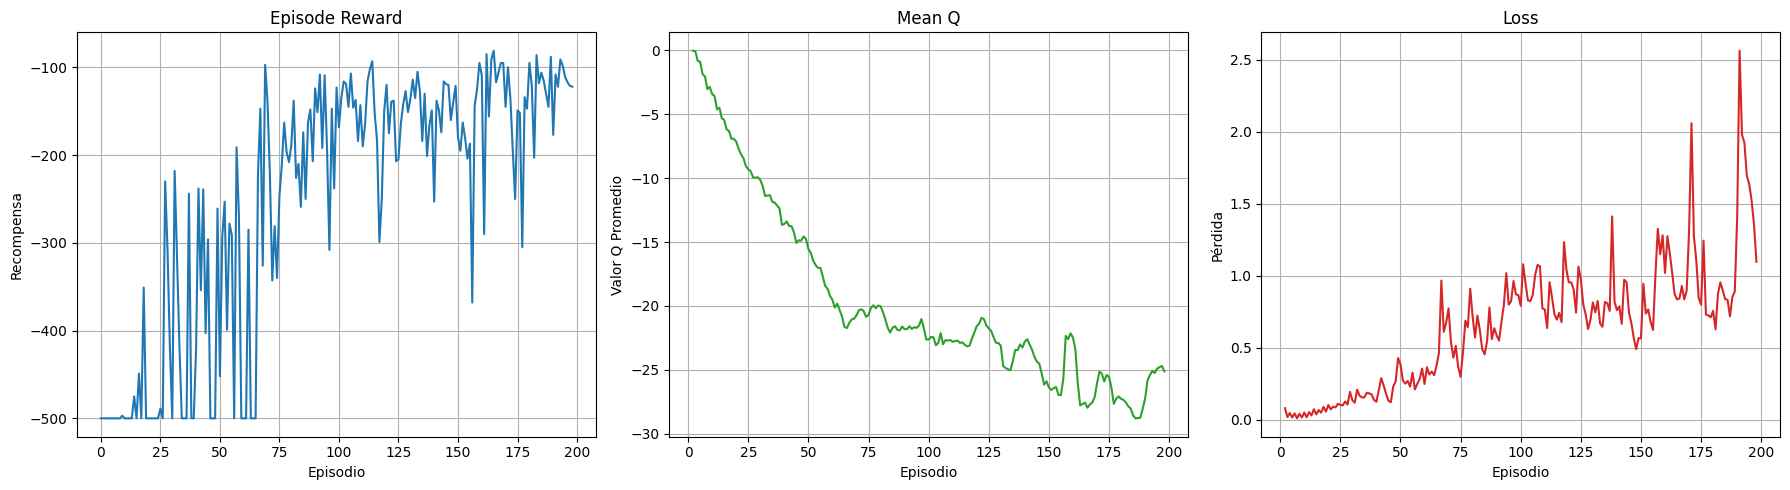

In [ ]:
# Visualizar curvas de entrenamiento
log_filename = 'baseline_{}_log.json'.format(env_name)
plot_training_metrics(log_filename)

---
### 0. Descripción del problema

El entorno del problema propuesto para este trabajo es Acrobot. Se trata de un sistema donde se simula un doble péndulo invertido a partir de un brazo de dos segmentos articulados, con un único motor que se encuentra situado en la articulación del codo.

Así, el objetivo es aprender a mover el brazo de forma que este consiga levantar su extremo por encima de una determinada altura, utilizando únicamente acciones sobre el codo. El episodio termina cuando este objetivo se alcanza, o si se agota el número máximo de pasos que se pueden dar, que son 500.

![Texto alternativo](https://gymnasium.farama.org/_images/acrobot.gif)

---
### 1. Mejorar la solución base

Con el objetivo de optimizar la configuración del baseline propuesto, se realizaron entrenamientos adicionales, cada uno modificando únicamente un hiperparámetro y así poder observar su impacto aislado sobre el rendimiento del agente.

Para poder evaluar el efecto de cada hiperparámetro, se procede a realizar en primer lugar una breve descripción de cada uno de ellos:

| **Parámetro**           | **Descripción**                                                                                                                                       |
|-------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|
| `memory_limit`          | Cantidad máxima de transiciones que se guardan en la memoria de replay. Permite que el agente aprenda de experiencias pasadas.                        |
| `window_length`         | Número de observaciones consecutivas que se utilizan como entrada.                                                                                     |
| `max_eps`               | Valor inicial de épsilon para la política ϵ-greedy. Se empieza con alta exploración.                                                                   |
| `min_eps`               | Valor mínimo que tomará épsilon. El valor de épsilon decae hasta alcanzar este mínimo.                                                                 |
| `test_eps`              | Valor de épsilon usado durante la fase de test. Suele ser bajo para favorecer la política aprendida.                                                   |
| `steps_exploration`     | Número de pasos durante los que se realiza la fase de exploración, permitiendo que épsilon decaiga.                                                    |
| `steps_warmup`          | Número de pasos iniciales sin entrenamiento para llenar la memoria antes de actualizar la red.                                                         |
| `gamma`                 | Factor de descuento de recompensas futuras. Indica cuánto se valoran las recompensas a largo plazo.                                                    |
| `target_model_update`   | Número de pasos entre cada actualización de la *target network*.                                                                                       |
| `train_interval`        | Frecuencia (en pasos) con la que se actualiza el modelo del agente.                                                                                    |
| `learning_rate`         | Tasa de aprendizaje del optimizador utilizada para ajustar los pesos de la red neuronal.                                                               |
| `nb_steps`              | Número total de pasos que se realizarán en el entorno durante el entrenamiento.                                                                        |
| `batch_size`            | Tamaño del conjunto de transiciones usadas para entrenar la red en cada actualización.                                                                 |


### Window lenght

El modelo base utiliza un window_length de 4, lo que implica que el agente considera una secuencia de cuatro estados pasados al tomar decisiones. En este análisis, se explorará si una configuración más simple (por ejemplo, window_length = 1) resulta suficiente para resolver el entorno, mejorando así la eficiencia y estabilidad del entrenamiento sin perder capacidad de aprendizaje.

In [ ]:
# WINDOW LENGTH
memory_limit_v1 = 1000
window_length_v1 = 1 # change here
max_eps_v1, min_eps_v1, test_eps_v1 = 1.0, 0.05, 0.05
steps_exploration_v1 = 45000
steps_warmup_v1 = 1000
gamma_v1 = 0.99
target_model_update_v1 = 1000
train_interval_v1 = 4
learning_rate_v1 = 1e-3
nb_steps_v1 = 50000
batch_size_v1 = 128


# Modelo simple
model_v1 = tf.keras.models.Sequential()
model_v1.add(tf.keras.layers.Flatten(input_shape=(window_length_v1,) + env.observation_space.shape))
model_v1.add(tf.keras.layers.Dense(16))
model_v1.add(tf.keras.layers.Activation('relu'))
model_v1.add(tf.keras.layers.Dense(16))
model_v1.add(tf.keras.layers.Activation('relu'))
model_v1.add(tf.keras.layers.Dense(nb_actions))
model_v1.add(tf.keras.layers.Activation('linear'))
print(model_v1.summary())

# Memory
memory_v1 = SequentialMemory(limit=memory_limit_v1, window_length=window_length_v1)

# Policy
policy_v1 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v1, value_min=min_eps_v1,
                                 value_test=test_eps_v1, nb_steps=steps_exploration_v1)

# Agente
egreed_dqn_v1 = DQNAgent(model=model_v1, nb_actions=nb_actions,
                         policy=policy_v1, memory=memory_v1,
                         nb_steps_warmup=steps_warmup_v1, gamma=gamma_v1,
                         target_model_update=target_model_update_v1,
                         train_interval=train_interval_v1, batch_size=batch_size_v1)

# Compilación
egreed_dqn_v1.compile(Adam(learning_rate=learning_rate_v1), metrics=['mae'])

# Entrenamiento
log_filename_v1 = 'baseline_v1_{}_log.json'.format(env_name)
callbacks_v1 = [FileLogger(log_filename_v1, interval=100)]
egreed_dqn_v1.fit(env, callbacks=callbacks_v1, nb_steps=nb_steps_v1, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v1.save_weights('baseline_v1_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 6)                 0         
                                                                 
 dense_74 (Dense)            (None, 16)                112       
                                                                 
 activation_24 (Activation)  (None, 16)                0         
                                                                 
 dense_75 (Dense)            (None, 16)                272       
                                                                 
 activation_25 (Activation)  (None, 16)                0         
                                                                 
 dense_76 (Dense)            (None, 3)                 51        
                                                                 
 activation_26 (Activation)  (None, 3)               

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 1.545s, episode steps: 500, steps per second: 324, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.922 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.500s, episode steps: 500, steps per second: 999, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.990 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 4.554s, episode steps: 500, steps per second: 110, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.998 [0.000, 2.000],  loss: 0.096800, mae: 0.586355, mean_q: -0.556344, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 1.324s, episode steps: 500, steps per second: 378, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.982 [0.000, 2.000],  loss: 0.009313, mae: 0.653033, mean_q: -0.840646, mean_eps: 0.963098
  2500/50000: episode: 5, duration: 1.398s, episode steps: 500, steps per second: 358, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.098 [0.000, 2.000],  loss: 0.046400, mae: 1.262361, mean_q: -1.704776, mean_eps: 0.952542
  3000/50000: episode: 6, duration: 1.361s, episode steps: 500, steps per second: 367, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.994 [0.000, 2.000],  loss: 0.006988, mae: 1.291411, mean_q: -1.830

Testing for 10 episodes ...
Episode 1: reward: -111.000, steps: 112
Episode 2: reward: -178.000, steps: 179
Episode 3: reward: -93.000, steps: 94
Episode 4: reward: -115.000, steps: 116
Episode 5: reward: -81.000, steps: 82
Episode 6: reward: -109.000, steps: 110
Episode 7: reward: -170.000, steps: 171
Episode 8: reward: -88.000, steps: 89
Episode 9: reward: -122.000, steps: 123
Episode 10: reward: -97.000, steps: 98
Recompensas en test (_v1): [-111.0, -178.0, -93.0, -115.0, -81.0, -109.0, -170.0, -88.0, -122.0, -97.0]
Recompensa media: -116.40
Desviación típica: 31.25


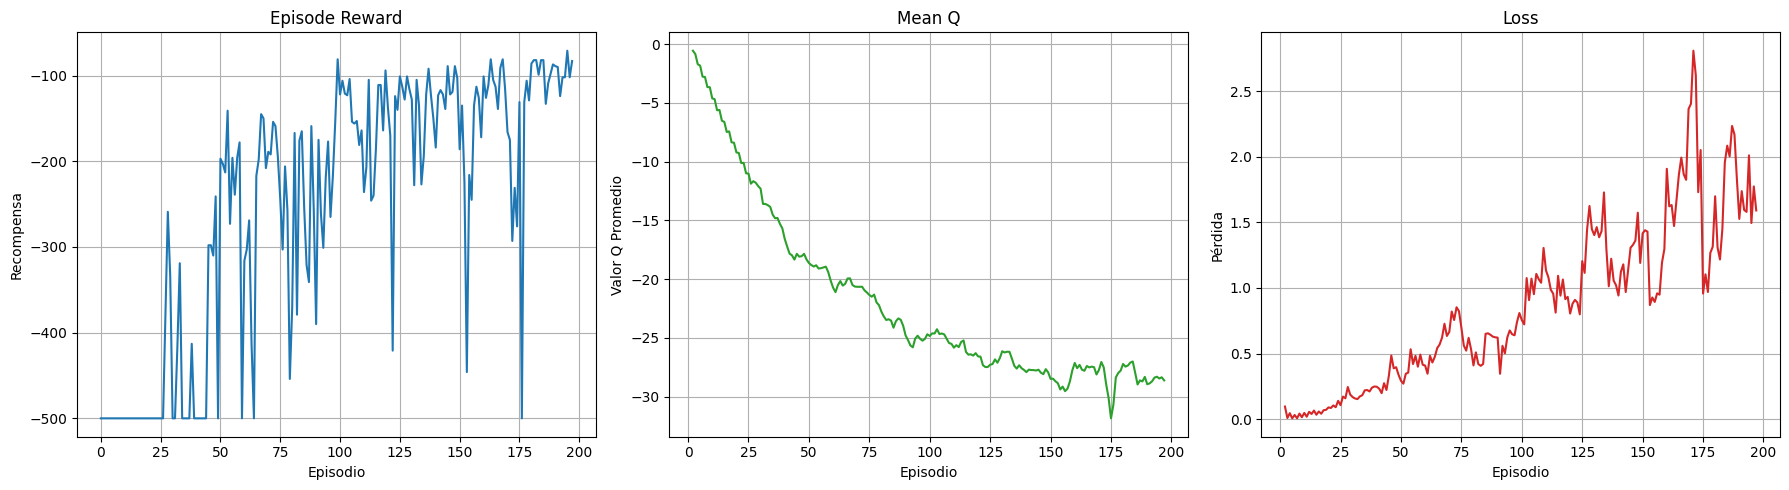

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v1.load_weights('baseline_v1_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v1 = egreed_dqn_v1.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v1 = test_history_v1.history['episode_reward']

# Resultados
print("Recompensas en test (_v1):", episodic_rewards_v1)
print(f"Recompensa media: {np.mean(episodic_rewards_v1):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v1):.2f}")

# Visualizar curvas de entrenamiento
log_filename_v1 = 'baseline_v1_{}_log.json'.format(env_name)
plot_training_metrics(log_filename_v1)

Al reducir el window_length a 1, se buscaba evaluar si un historial más corto de observaciones afectaba el rendimiento del agente. Los resultados muestran que este cambio puede ser beneficioso en términos de estabilidad y eficiencia: el intento 1 obtuvo una recompensa media notablemente mejor que los tres intentos del modelo baseline original (cuya media oscilaba entre -419 y -436). Además, la desviación típica es mucho más baja, lo cual indica mayor consistencia entre episodios.

Intento   | Recompensa Media   | Desviación Típica
--------- | ------------------ | ------------------
1         | -104.10            | 28.89
2         | -131.60            | 13.12
3         | -116.40            | 31.25

Esto sugiere que, para el entorno Acrobot-v1, el uso de un window_length corto permite que el modelo aprenda de forma más rápida y estable, posiblemente porque las observaciones más recientes contienen suficiente información relevante para tomar decisiones efectivas.

### Memory limit
Se observa que el modelo baseline utiliza una *memory_limit* de 1.000. Probar un valor más pequeño no tiene sentido porque si usamos menos de 1.000 experiencias, el agente no va a tener suficiente variedad para aprender bien y se va a volver inestable, por eso por vamos a probar con una memoria bastante más grande (x20) para que pueda recordar más situaciones:

In [ ]:
#MEMORY LIMIT
memory_limit_v2 = 20000 # change here
window_length_v2 = 1
max_eps_v2, min_eps_v2, test_eps_v2 = 1.0, 0.05, 0.05
steps_exploration_v2 = 45000
steps_warmup_v2 = 1000
gamma_v2 = 0.99
target_model_update_v2 = 1000
train_interval_v2 = 4
learning_rate_v2 = 1e-3
nb_steps_v2 = 50000
batch_size_v2 = 128


model_v2 = tf.keras.models.Sequential()
model_v2.add(tf.keras.layers.Flatten(input_shape=(window_length_v2,) + env.observation_space.shape))
model_v2.add(tf.keras.layers.Dense(16, activation='relu'))
model_v2.add(tf.keras.layers.Dense(16, activation='relu'))
model_v2.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v2.summary()

memory_v2 = SequentialMemory(limit=memory_limit_v2, window_length=window_length_v2)
policy_v2 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v2, value_min=min_eps_v2,
                                 value_test=test_eps_v2, nb_steps=steps_exploration_v2)

egreed_dqn_v2 = DQNAgent(model=model_v2, nb_actions=nb_actions,
                         policy=policy_v2, memory=memory_v2,
                         nb_steps_warmup=steps_warmup_v2, gamma=gamma_v2,
                         target_model_update=target_model_update_v2,
                         train_interval=train_interval_v2, batch_size=batch_size_v2)

# Compilación
egreed_dqn_v2.compile(Adam(learning_rate=learning_rate_v2), metrics=['mae'])

# Entrenamiento
log_filename_v2 = 'baseline_v2_{}_log.json'.format(env_name)
callbacks_v2 = [FileLogger(log_filename_v2, interval=100)]
egreed_dqn_v2.fit(env, callbacks=callbacks_v2, nb_steps=nb_steps_v2, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v2.save_weights('baseline_v2_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 6)                 0         
                                                                 
 dense_138 (Dense)           (None, 16)                112       
                                                                 
 dense_139 (Dense)           (None, 16)                272       
                                                                 
 dense_140 (Dense)           (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
Training for 50000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 2.684s, episode steps: 500, steps per second: 186, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.996 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.678s, episode steps: 500, steps per second: 737, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.068 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 8.508s, episode steps: 500, steps per second:  59, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.038 [0.000, 2.000],  loss: 0.076688, mae: 0.555926, mean_q: -0.542449, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 1.736s, episode steps: 500, steps per second: 288, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.996 [0.000, 2.000],  loss: 0.009871, mae: 0.612819, mean_q: -0.799411, mean_eps: 0.963098
  2500/50000: episode: 5, duration: 1.742s, episode steps: 500, steps per second: 287, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.014 [0.000, 2.000],  loss: 0.043155, mae: 1.226491, mean_q: -1.680794, mean_eps: 0.952542
  3000/50000: episode: 6, duration: 1.777s, episode steps: 500, steps per second: 281, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.982 [0.000, 2.000],  loss: 0.005791, mae: 1.243701, mean_q: -1.776

Testing for 10 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -192.000, steps: 193
Episode 3: reward: -190.000, steps: 191
Episode 4: reward: -500.000, steps: 500
Episode 5: reward: -201.000, steps: 202
Episode 6: reward: -500.000, steps: 500
Episode 7: reward: -178.000, steps: 179
Episode 8: reward: -145.000, steps: 146
Episode 9: reward: -500.000, steps: 500
Episode 10: reward: -500.000, steps: 500
Recompensas en test (_v2): [-500.0, -192.0, -190.0, -500.0, -201.0, -500.0, -178.0, -145.0, -500.0, -500.0]
Recompensa media: -340.60
Desviación típica: 160.00


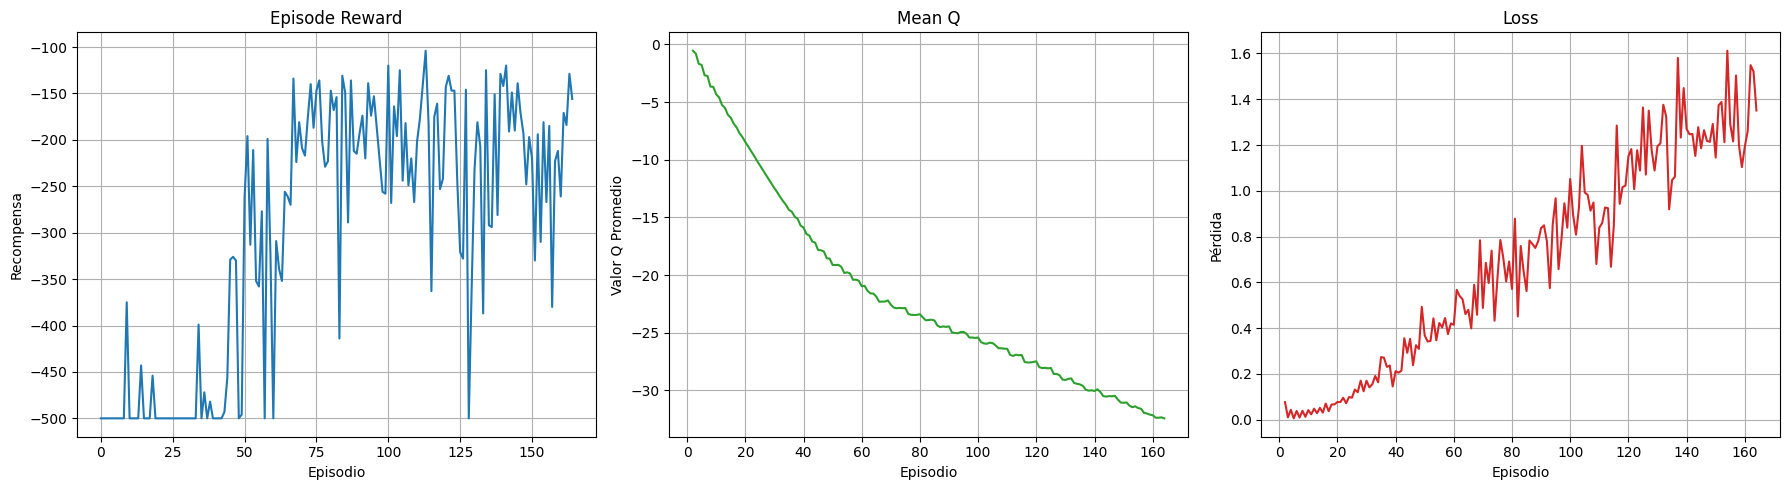

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v2.load_weights('baseline_v2_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v2 = egreed_dqn_v2.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v2 = test_history_v2.history['episode_reward']

# Resultados
print("Recompensas en test (_v2):", episodic_rewards_v2)
print(f"Recompensa media: {np.mean(episodic_rewards_v2):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v2):.2f}")

# Visualizar curvas de entrenamiento
log_filename_v2 = 'baseline_v2_{}_log.json'.format(env_name)
plot_training_metrics(log_filename_v2)

Se ha aumentado el memory_limit a 20.000 y, aunque podría parecer mucho, el tiempo de entrenamiento apenas ha subido y sigue yendo bastante fluido, así que se ha decidido dejarlo así. Por sí solo este cambio no ha mejorado los resultados, pero vamos a probarlo junto con otros cambios (train inverval) y comprobar sí se nota que tener más memoria ayuda a que el agente aprenda de forma más estable y aproveche mejor las mejoras. A continuación vemos estos otros cambios.

### Train interval

Se va a analizar el efecto de reducir el valor del parámetro train_interval, que determina cada cuántos pasos del entorno se actualiza la red neuronal del agente. Un valor menor, como train_interval = 2, implica que el agente entrena su red en cada paso, lo que puede acelerar el proceso de aprendizaje al aprovechar mejor cada experiencia acumulada. Este ajuste podría mejorar la eficiencia y adaptabilidad del agente en entornos complejos, aunque también se debe evaluar su impacto en la estabilidad del entrenamiento. El objetivo es determinar si entrenar con mayor frecuencia contribuye a obtener recompensas más altas y un comportamiento más consistente.

In [ ]:
# Training interval
memory_limit_v3 = 20000 # change here
window_length_v3 = 1
max_eps_v3, min_eps_v3, test_eps_v3 = 1.0, 0.05, 0.05
steps_exploration_v3 = 45000
steps_warmup_v3 = 1000
gamma_v3 = 0.99
target_model_update_v3 = 1000
train_interval_v3 = 1 # change here
learning_rate_v3 = 1e-3
nb_steps_v3 = 50000
batch_size_v3 = 128


model_v3 = tf.keras.models.Sequential()
model_v3.add(tf.keras.layers.Flatten(input_shape=(window_length_v3,) + env.observation_space.shape))
model_v3.add(tf.keras.layers.Dense(16, activation='relu'))
model_v3.add(tf.keras.layers.Dense(16, activation='relu'))
model_v3.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v3.summary()

memory_v3 = SequentialMemory(limit=memory_limit_v3, window_length=window_length_v3)
policy_v3 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v3, value_min=min_eps_v3,
                                 value_test=test_eps_v3, nb_steps=steps_exploration_v3)

egreed_dqn_v3 = DQNAgent(model=model_v3, nb_actions=nb_actions,
                         policy=policy_v3, memory=memory_v3,
                         nb_steps_warmup=steps_warmup_v3, gamma=gamma_v3,
                         target_model_update=target_model_update_v3,
                         train_interval=train_interval_v3, batch_size=batch_size_v3)

# Compilación
egreed_dqn_v3.compile(Adam(learning_rate=learning_rate_v3), metrics=['mae'])
log_filename_v3 = 'baseline_v3_{}_log.json'.format(env_name)
callbacks_v3 = [FileLogger(log_filename_v3, interval=100)]

# Entrenamiento
egreed_dqn_v3.fit(env, callbacks=callbacks_v3, nb_steps=nb_steps_v3, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v3.save_weights('baseline_v3_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 6)                 0         
                                                                 
 dense_9 (Dense)             (None, 16)                112       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
Training for 50000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 2.208s, episode steps: 500, steps per second: 226, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.034 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.363s, episode steps: 500, steps per second: 1378, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.942 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 3.402s, episode steps: 500, steps per second: 147, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.984 [0.000, 2.000],  loss: 0.033201, mae: 0.615566, mean_q: -0.724060, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 2.594s, episode steps: 500, steps per second: 193, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.078 [0.000, 2.000],  loss: 0.005479, mae: 0.623631, mean_q: -0.831654, mean_eps: 0.963066
  2500/50000: episode: 5, duration: 2.659s, episode steps: 500, steps per second: 188, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.058 [0.000, 2.000],  loss: 0.012547, mae: 1.267531, mean_q: -1.806730, mean_eps: 0.952511
  3000/50000: episode: 6, duration: 2.787s, episode steps: 500, steps per second: 179, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.028 [0.000, 2.000],  loss: 0.003608, mae: 1.261881, mean_q: -1.820

Testing for 10 episodes ...
Episode 1: reward: -98.000, steps: 99
Episode 2: reward: -112.000, steps: 113
Episode 3: reward: -62.000, steps: 63
Episode 4: reward: -120.000, steps: 121
Episode 5: reward: -90.000, steps: 91
Episode 6: reward: -87.000, steps: 88
Episode 7: reward: -85.000, steps: 86
Episode 8: reward: -92.000, steps: 93
Episode 9: reward: -90.000, steps: 91
Episode 10: reward: -84.000, steps: 85
Recompensas en test (_v3): [-98.0, -112.0, -62.0, -120.0, -90.0, -87.0, -85.0, -92.0, -90.0, -84.0]
Recompensa media: -92.00
Desviación típica: 15.05


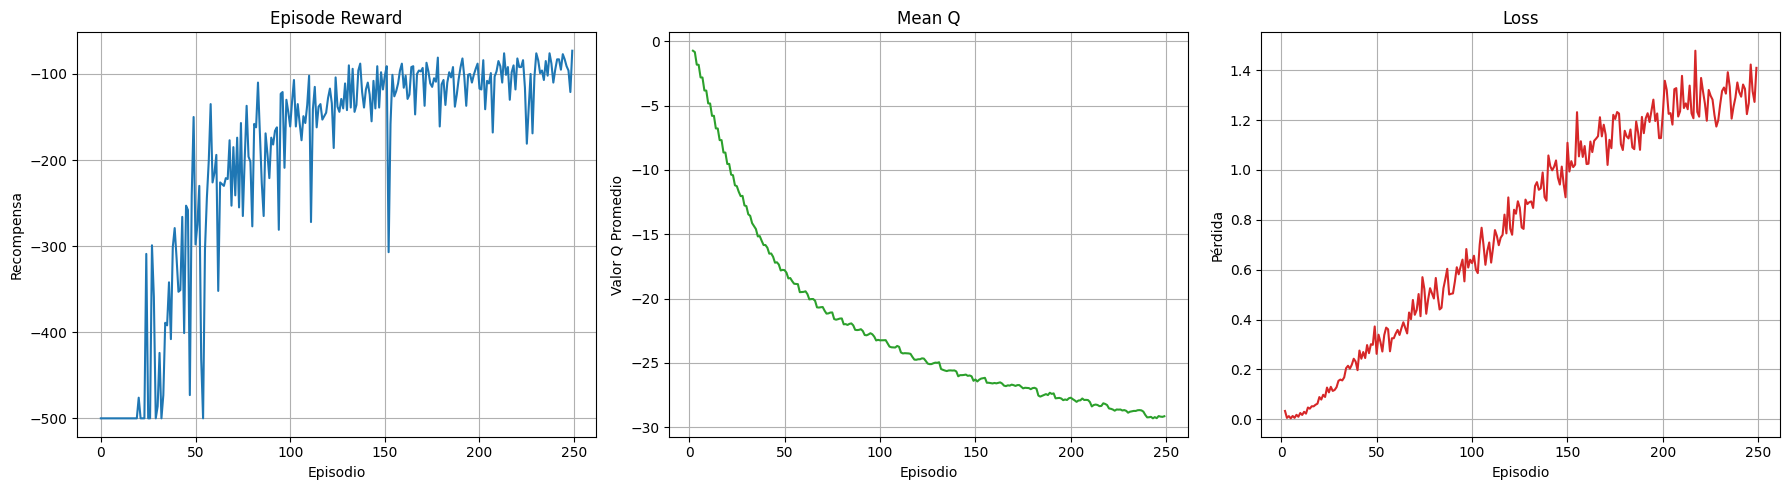

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v3.load_weights('baseline_v3_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v3 = egreed_dqn_v3.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v3 = test_history_v3.history['episode_reward']

# Resultados
print("Recompensas en test (_v3):", episodic_rewards_v3)
print(f"Recompensa media: {np.mean(episodic_rewards_v3):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v3):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename_v3)

Se probaron distintos valores con el objetivo de evaluar su impacto en la eficiencia y estabilidad del aprendizaje. Los resultados obtenidos mostraron que el valor más eficiente y estable fue train_interval = 1, ya que permitió al agente actualizarse en cada paso y, con ello, aprovechar mejor cada experiencia. Como puede observarse en la figura, el agente alcanzó una recompensa media de -92.00 en el último intento con una baja desviación típica de 15.05, lo que indica un comportamiento consistente y una mejora significativa frente a configuraciones menos frecuentes de entrenamiento.

Los resultados fueron los siguientes:

Intento   | Recompensa Media | Desviación Típica
--------- | ---------------- | ------------------
1         | -104.10          | 17.06
2         | -79.07           | 13.87
3         | -92.00           | 15.05

Durante este experimento, también se decidió aumentar el valor de ***memory_limit a 20.000***, permitiendo así almacenar una mayor cantidad de experiencias pasadas en la memoria del agente. Aunque en pruebas anteriores este cambio aislado no generó mejoras notables, su combinación con una mayor frecuencia de entrenamiento (train_interval = 1) sí produjo un efecto positivo. La clave de esta mejora parece residir en que, al entrenar más a menudo, el agente puede aprovechar de forma más eficaz la diversidad de experiencias almacenadas. De esta forma, la ampliación del buffer de memoria se vuelve significativa cuando el modelo tiene acceso frecuente a sus datos y los puede reutilizar eficientemente, contribuyendo así a un aprendizaje más robusto.

### Batch size

Con el objetivo de analizar el impacto del tamaño del batch sobre el rendimiento del agente, se evaluó la reducción del parámetro batch_size de 128 a 64 manteniendo constantes el resto de los hiperparámetros. Esta modificación implica que el agente actualiza su red neuronal con menos muestras por iteración, lo cual puede acelerar el proceso de entrenamiento y reducir el uso de memoria. Sin embargo, trabajar con lotes más pequeños también puede introducir mayor variabilidad en las actualizaciones, afectando potencialmente la estabilidad del aprendizaje. Por tanto, se pretende comprobar si esta reducción permite mantener una buena eficiencia y rendimiento, o si por el contrario deteriora la calidad del aprendizaje del agente.

In [ ]:
#BATCH SIZE
memory_limit_v4 = 20000
window_length_v4 = 1
max_eps_v4, min_eps_v4, test_eps_v4 = 1.0, 0.05, 0.05
steps_exploration_v4 = 45000
steps_warmup_v4 = 1000
gamma_v4 = 0.99
target_model_update_v4 = 1000
train_interval_v4 = 1
learning_rate_v4 = 1e-3
nb_steps_v4 = 50000
batch_size_v4 = 64 # change here


model_v4 = tf.keras.models.Sequential()
model_v4.add(tf.keras.layers.Flatten(input_shape=(window_length_v4,) + env.observation_space.shape))
model_v4.add(tf.keras.layers.Dense(16, activation='relu'))
model_v4.add(tf.keras.layers.Dense(16, activation='relu'))
model_v4.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v4.summary()

memory_v4 = SequentialMemory(limit=memory_limit_v4, window_length=window_length_v4)
policy_v4 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v4, value_min=min_eps_v4,
                                 value_test=test_eps_v4, nb_steps=steps_exploration_v4)

egreed_dqn_v4 = DQNAgent(model=model_v4, nb_actions=nb_actions,
                         policy=policy_v4, memory=memory_v4,
                         nb_steps_warmup=steps_warmup_v4, gamma=gamma_v4,
                         target_model_update=target_model_update_v4,
                         train_interval=train_interval_v4, batch_size=batch_size_v4)

# Compilación
egreed_dqn_v4.compile(Adam(learning_rate=learning_rate_v4), metrics=['mae'])

# Entrenamiento
log_filename_v4 = 'baseline_v4_{}_log.json'.format(env_name)
callbacks_v4 = [FileLogger(log_filename_v4, interval=100)]
egreed_dqn_v4.fit(env, callbacks=callbacks_v4, nb_steps=nb_steps_v4, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v4.save_weights('baseline_v4_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 6)                 0         
                                                                 
 dense_119 (Dense)           (None, 16)                112       
                                                                 
 dense_120 (Dense)           (None, 16)                272       
                                                                 
 dense_121 (Dense)           (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
Training for 50000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 2.491s, episode steps: 500, steps per second: 201, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.042 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.622s, episode steps: 500, steps per second: 804, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.014 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 9.826s, episode steps: 500, steps per second:  51, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.066 [0.000, 2.000],  loss: 0.032973, mae: 0.512553, mean_q: -0.573873, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 4.370s, episode steps: 500, steps per second: 114, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.952 [0.000, 2.000],  loss: 0.003901, mae: 0.519961, mean_q: -0.709112, mean_eps: 0.963066
  2500/50000: episode: 5, duration: 4.300s, episode steps: 500, steps per second: 116, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.034 [0.000, 2.000],  loss: 0.010802, mae: 1.167378, mean_q: -1.677822, mean_eps: 0.952511
  3000/50000: episode: 6, duration: 4.341s, episode steps: 500, steps per second: 115, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.066 [0.000, 2.000],  loss: 0.002229, mae: 1.159078, mean_q: -1.691

Testing for 10 episodes ...
Episode 1: reward: -120.000, steps: 121
Episode 2: reward: -105.000, steps: 106
Episode 3: reward: -500.000, steps: 500
Episode 4: reward: -348.000, steps: 349
Episode 5: reward: -500.000, steps: 500
Episode 6: reward: -500.000, steps: 500
Episode 7: reward: -500.000, steps: 500
Episode 8: reward: -107.000, steps: 108
Episode 9: reward: -500.000, steps: 500
Episode 10: reward: -102.000, steps: 103
Recompensas en test (_v4): [-120.0, -105.0, -500.0, -348.0, -500.0, -500.0, -500.0, -107.0, -500.0, -102.0]
Recompensa media: -328.20
Desviación típica: 184.72


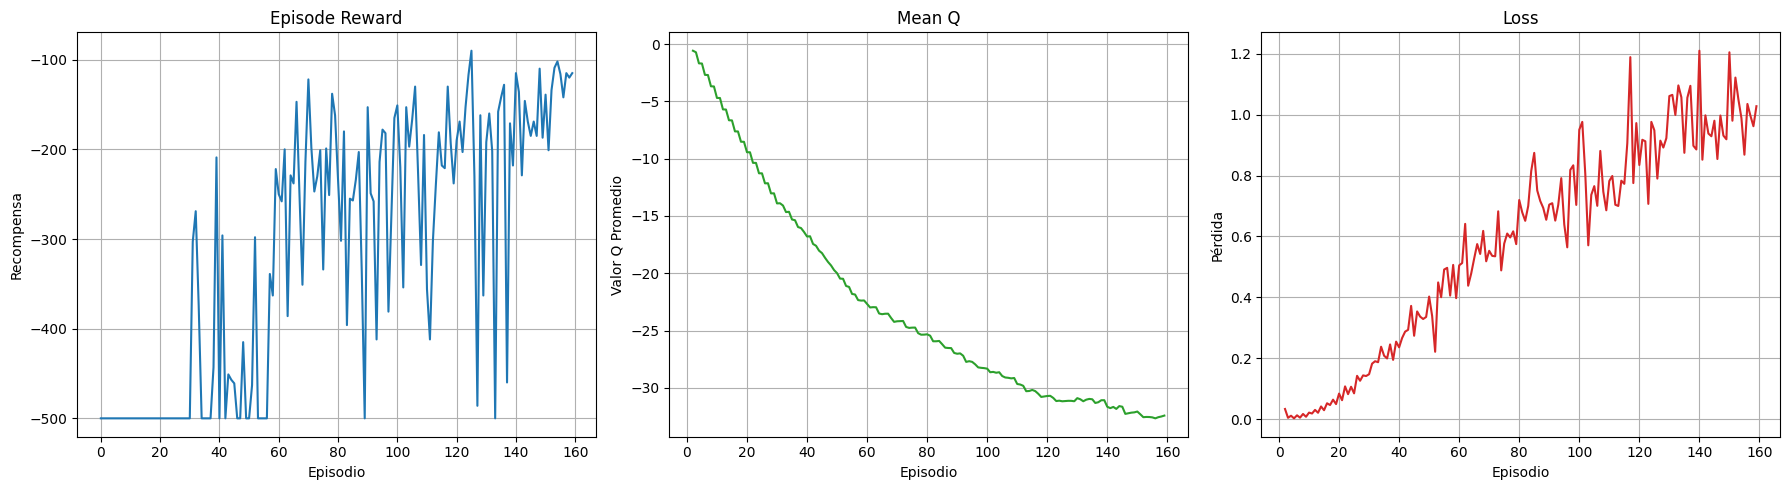

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v4.load_weights('baseline_v4_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v4 = egreed_dqn_v4.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v4 = test_history_v4.history['episode_reward']

# Resultados
print("Recompensas en test (_v4):", episodic_rewards_v4)
print(f"Recompensa media: {np.mean(episodic_rewards_v4):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v4):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename_v4)

Se realizaron tres evaluaciones con batch_size = 64 para confirmar la estabilidad del entrenamiento.

Intento   | Recompensa Media   | Desviación Típica
----------|--------------------|-------------------
1         | -270.50            | 190.80
2         | -217.70            | 185.36
3         | -328.20            | 184.72

En esta última repetición, el agente obtuvo una recompensa media de -328.20 y una desviación típica de 184.72, similares a los resultados anteriores, lo que refuerza la conclusión de que reducir el tamaño del batch no mejora el rendimiento. A pesar de que la pérdida sigue una tendencia esperada, las recompensas son bajas y presentan gran variabilidad, lo que sugiere que el agente tiene dificultades para generalizar. Por tanto, mantener un batch mayor (por ejemplo, 128) resulta más efectivo en este entorno.

### Learning rate

Vamos a evaluar cómo afecta la reducción del learning rate de 1e-3 a 5e-4 al comportamiento del agente durante el entrenamiento. Este parámetro controla la magnitud con la que se ajustan los pesos de la red neuronal en cada paso del optimizador. Un valor más bajo implica actualizaciones más pequeñas y, potencialmente, más estables, lo que puede ser beneficioso cuando se busca una convergencia suave y se quiere evitar el sobreajuste o las oscilaciones en la política aprendida. En este experimento, observaremos si este ajuste permite mejorar la estabilidad del aprendizaje y alcanzar recompensas más altas de forma sostenida.

In [ ]:
#LEARNING RATE
memory_limit_v5 = 20000
window_length_v5 = 1
max_eps_v5, min_eps_v5, test_eps_v5 = 1.0, 0.05, 0.05
steps_exploration_v5 = 45000
steps_warmup_v5 = 1000
gamma_v5 = 0.99
target_model_update_v5 = 1000
train_interval_v5 = 1
learning_rate_v5 = 5e-4 # change here
nb_steps_v5 = 50000
batch_size_v5 = 128


model_v5 = tf.keras.models.Sequential()
model_v5.add(tf.keras.layers.Flatten(input_shape=(window_length_v5,) + env.observation_space.shape))
model_v5.add(tf.keras.layers.Dense(16, activation='relu'))
model_v5.add(tf.keras.layers.Dense(16, activation='relu'))
model_v5.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v5.summary()

memory_v5 = SequentialMemory(limit=memory_limit_v5, window_length=window_length_v5)
policy_v5 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v5, value_min=min_eps_v5,
                                 value_test=test_eps_v5, nb_steps=steps_exploration_v5)

egreed_dqn_v5 = DQNAgent(model=model_v5, nb_actions=nb_actions,
                         policy=policy_v5, memory=memory_v5,
                         nb_steps_warmup=steps_warmup_v5, gamma=gamma_v5,
                         target_model_update=target_model_update_v5,
                         train_interval=train_interval_v5, batch_size=batch_size_v5)

# Compilación
egreed_dqn_v5.compile(Adam(learning_rate=learning_rate_v5), metrics=['mae'])

# Entrenamiento
log_filename_v5 = 'baseline_v5_{}_log.json'.format(env_name)
callbacks_v5 = [FileLogger(log_filename_v5, interval=100)]
egreed_dqn_v5.fit(env, callbacks=callbacks_v5, nb_steps=nb_steps_v5, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v5.save_weights('baseline_v5_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 6)                 0         
                                                                 
 dense_49 (Dense)            (None, 16)                112       
                                                                 
 dense_50 (Dense)            (None, 16)                272       
                                                                 
 dense_51 (Dense)            (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
Training for 50000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 1.144s, episode steps: 500, steps per second: 437, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.974 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.473s, episode steps: 500, steps per second: 1057, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.998 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 5.913s, episode steps: 500, steps per second:  85, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.958 [0.000, 2.000],  loss: 0.184859, mae: 0.446043, mean_q: 0.357443, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 3.391s, episode steps: 500, steps per second: 147, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.002 [0.000, 2.000],  loss: 0.018329, mae: 0.440566, mean_q: 0.139914, mean_eps: 0.963066
  2500/50000: episode: 5, duration: 3.430s, episode steps: 500, steps per second: 146, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.948 [0.000, 2.000],  loss: 0.037273, mae: 0.775486, mean_q: -0.760576, mean_eps: 0.952511
  3000/50000: episode: 6, duration: 3.507s, episode steps: 500, steps per second: 143, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.014 [0.000, 2.000],  loss: 0.008466, mae: 0.791440, mean_q: -0.83571

Testing for 10 episodes ...
Episode 1: reward: -90.000, steps: 91
Episode 2: reward: -97.000, steps: 98
Episode 3: reward: -83.000, steps: 84
Episode 4: reward: -84.000, steps: 85
Episode 5: reward: -149.000, steps: 150
Episode 6: reward: -116.000, steps: 117
Episode 7: reward: -182.000, steps: 183
Episode 8: reward: -89.000, steps: 90
Episode 9: reward: -111.000, steps: 112
Episode 10: reward: -92.000, steps: 93
Recompensas en test (_v5): [-90.0, -97.0, -83.0, -84.0, -149.0, -116.0, -182.0, -89.0, -111.0, -92.0]
Recompensa media: -109.30
Desviación típica: 30.78


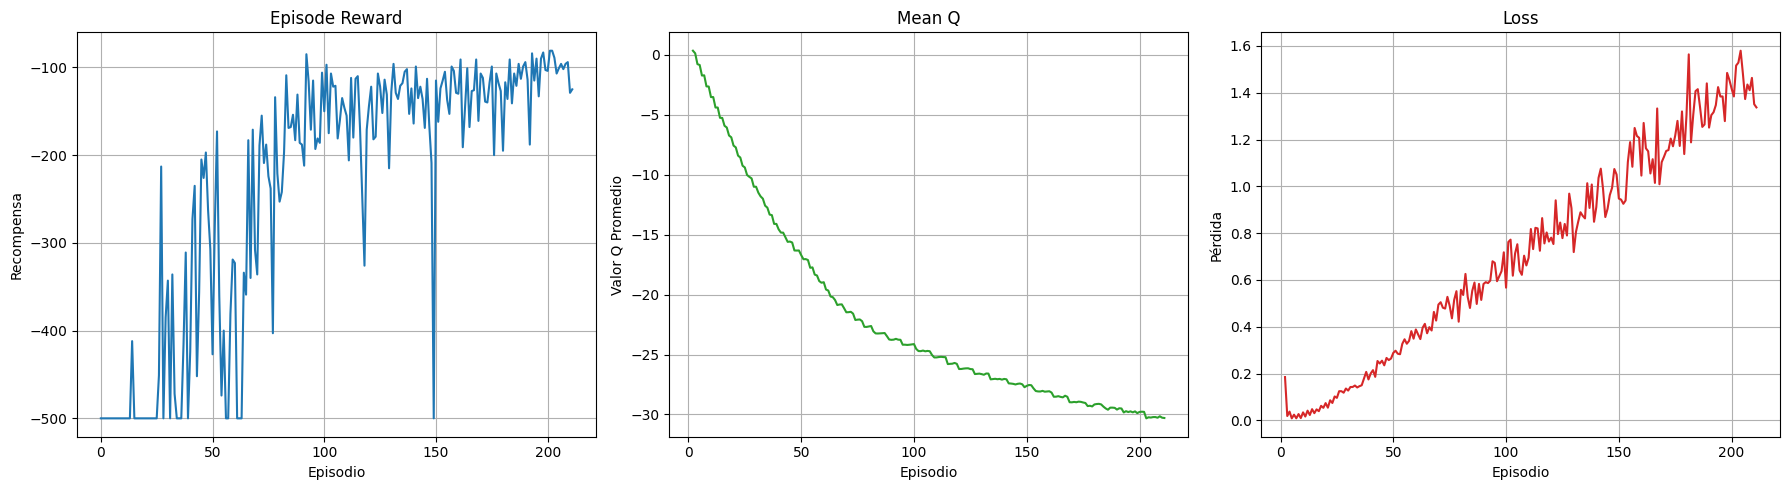

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v5.load_weights('baseline_v5_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v5 = egreed_dqn_v5.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v5 = test_history_v5.history['episode_reward']

# Resultados
print("Recompensas en test (_v5):", episodic_rewards_v5)
print(f"Recompensa media: {np.mean(episodic_rewards_v5):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v5):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename_v5)

Aunque esperábamos que reducir el learning rate mejorara la estabilidad, en la práctica, los resultados con 5e-4 fueron más inconsistentes y con peor rendimiento medio. Solo un intento fue bueno, pero el resto tuvo caídas grandes.

Intento   | Recompensa Media   | Desviación Típica
----------|--------------------|-------------------
1         | -173.60            | 164.40
2         | -265.80            | 185.36
3         | -109.30            | 30.78



Los resultados muestran que, con una tasa de aprendizaje de 5e-4, el rendimiento del agente fue más bajo y menos estable en comparación con los entrenamientos anteriores con 1e-3. Por lo tanto, se concluye que una tasa de aprendizaje de 1e-3 es suficiente para garantizar un aprendizaje eficiente y una mejor recompensa media, evitando al mismo tiempo oscilaciones extremas. Ajustes más pequeños en el learning rate no aportaron mejoras claras en este caso.

### Target model

Este hiperparámetro controla cada cuántos pasos se actualiza la red objetivo (target network), que actúa como referencia estable para el cálculo de los valores Q. Reducir su valor implica actualizaciones más frecuentes, lo que podría favorecer una adaptación más ágil del agente, aunque también existe el riesgo de introducir más inestabilidad. Por tanto, se explorará si esta modificación mejora el rendimiento en comparación con el valor base.

In [ ]:
# TARGET MODEL
memory_limit_v6 = 20000
window_length_v6 = 1
max_eps_v6, min_eps_v6, test_eps_v6 = 1.0, 0.05, 0.05
steps_exploration_v6 = 45000
steps_warmup_v6 = 1000
gamma_v6 = 0.99
target_model_update_v6 = 250 # change here
train_interval_v6 = 1
learning_rate_v6 = 1e-3
nb_steps_v6 = 50000
batch_size_v6 = 128

# Modelo
model_v6 = tf.keras.models.Sequential()
model_v6.add(tf.keras.layers.Flatten(input_shape=(window_length_v6,) + env.observation_space.shape))
model_v6.add(tf.keras.layers.Dense(16, activation='relu'))
model_v6.add(tf.keras.layers.Dense(16, activation='relu'))
model_v6.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v6.summary()


# Memoria y política
memory_v6 = SequentialMemory(limit=memory_limit_v6, window_length=window_length_v6)
policy_v6 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v6, value_min=min_eps_v6,
                                 value_test=test_eps_v6, nb_steps=steps_exploration_v6)

# Agente
egreed_dqn_v6 = DQNAgent(model=model_v6, nb_actions=nb_actions,
                         policy=policy_v6, memory=memory_v6,
                         nb_steps_warmup=steps_warmup_v6, gamma=gamma_v6,
                         target_model_update=target_model_update_v6,
                         train_interval=train_interval_v6, batch_size=batch_size_v6)

# Compilación
egreed_dqn_v6.compile(Adam(learning_rate=learning_rate_v6), metrics=['mae'])

# Entrenamiento
log_filename_v6 = 'baseline_v6_{}_log.json'.format(env_name)
callbacks_v6 = [FileLogger(log_filename_v6, interval=100)]
egreed_dqn_v6.fit(env, callbacks=callbacks_v6, nb_steps=nb_steps_v6, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v6.save_weights('baseline_v6_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 6)                 0         
                                                                 
 dense_95 (Dense)            (None, 16)                112       
                                                                 
 dense_96 (Dense)            (None, 16)                272       
                                                                 
 dense_97 (Dense)            (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
Training for 50000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 1.840s, episode steps: 500, steps per second: 272, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.966 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.550s, episode steps: 500, steps per second: 910, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.998 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/50000: episode: 3, duration: 8.593s, episode steps: 500, steps per second:  58, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.048 [0.000, 2.000],  loss: 0.042170, mae: 0.701732, mean_q: -0.828576, mean_eps: 0.973611
  2000/50000: episode: 4, duration: 4.071s, episode steps: 500, steps per second: 123, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.992 [0.000, 2.000],  loss: 0.019711, mae: 1.947133, mean_q: -2.804684, mean_eps: 0.963066
  2500/50000: episode: 5, duration: 4.124s, episode steps: 500, steps per second: 121, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.980 [0.000, 2.000],  loss: 0.029200, mae: 3.204080, mean_q: -4.692730, mean_eps: 0.952511
  3000/50000: episode: 6, duration: 4.057s, episode steps: 500, steps per second: 123, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.080 [0.000, 2.000],  loss: 0.041443, mae: 4.405057, mean_q: -6.475

Testing for 10 episodes ...
Episode 1: reward: -85.000, steps: 86
Episode 2: reward: -101.000, steps: 102
Episode 3: reward: -111.000, steps: 112
Episode 4: reward: -71.000, steps: 72
Episode 5: reward: -70.000, steps: 71
Episode 6: reward: -116.000, steps: 117
Episode 7: reward: -87.000, steps: 88
Episode 8: reward: -105.000, steps: 106
Episode 9: reward: -100.000, steps: 101
Episode 10: reward: -116.000, steps: 117
Recompensas en test (_v6): [-85.0, -101.0, -111.0, -71.0, -70.0, -116.0, -87.0, -105.0, -100.0, -116.0]
Recompensa media: -96.20
Desviación típica: 16.28


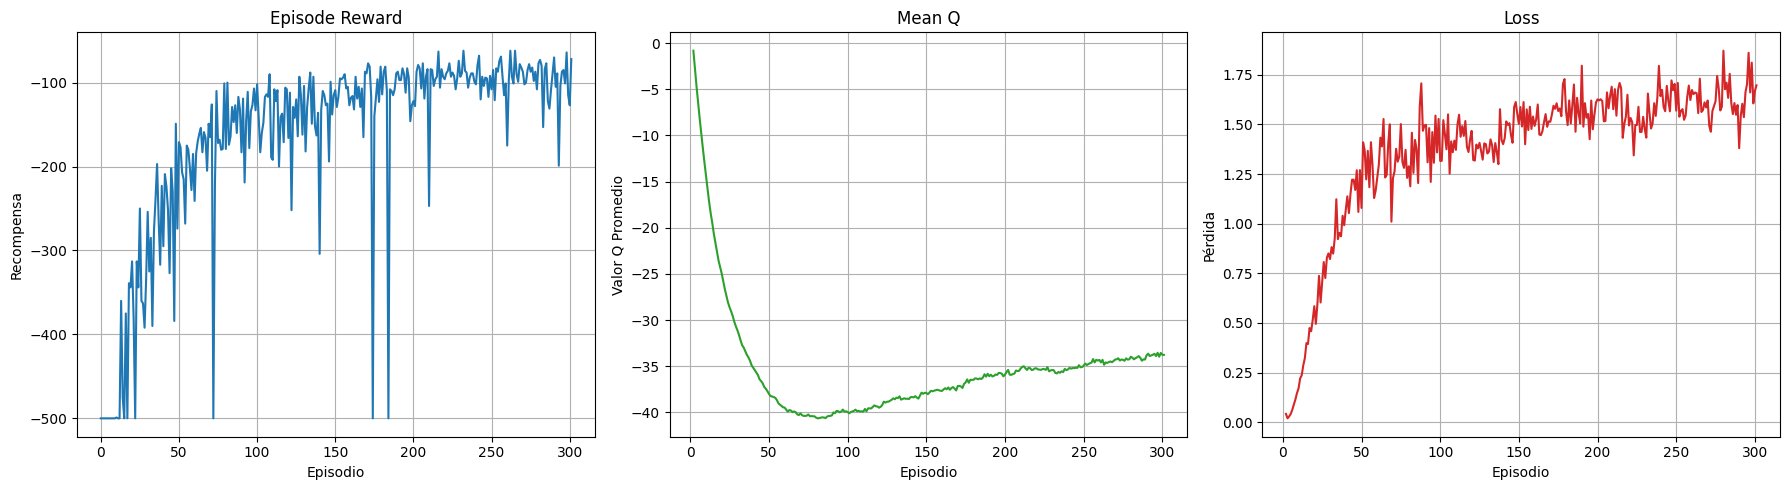

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v6.load_weights('baseline_v6_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v6 = egreed_dqn_v6.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v6 = test_history_v6.history['episode_reward']

# Resultados
print("Recompensas en test (_v6):", episodic_rewards_v6)
print(f"Recompensa media: {np.mean(episodic_rewards_v6):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v6):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename_v6)

Los tres intentos muestran valores consistentes, con una recompensa media en torno a -95 y desviaciones típicas relativamente bajas. Esto sugiere que el modelo con target_model_update = 250 ofrece un rendimiento estable y reproducible, sin variaciones bruscas entre ejecuciones. Aunque no es el modelo con la mayor recompensa observada en todas las pruebas realizadas, sí demuestra una buena regularidad, lo cual es valioso cuando se busca fiabilidad en entornos ruidosos o con alta variabilidad.

Intento   | Recompensa Media | Desviación Típica
--------- | ---------------- | ------------------
1         | -91.10           | 18.45
2         | -85.60           | 15.87
3         | -96.20           | 16.28

### Epsilon max



En el siguiente apartado se ha reducido epsilon_max de 1.0 a 0.8 para limitar la exploración aleatoria inicial, y se ha bajado epsilon_min de 0.05 a 0.02 para mantener una mínima exploración en fases avanzadas del entrenamiento. Se espera que estos cambios favorezcan un aprendizaje más dirigido desde el inicio, reduciendo la probabilidad de tomar decisiones completamente aleatorias, y que permitan cierta flexibilidad en la política aprendida al final. Analizar esta configuración permite evaluar si un ajuste más fino de la estrategia de exploración puede mejorar la estabilidad, la eficiencia del aprendizaje y el rendimiento final del agente.

In [ ]:
# Epsilon max, epsilon min
memory_limit_v7 = 20000
window_length_v7 = 1
max_eps_v7, min_eps_v7, test_eps_v7 = 0.8, 0.02, 0.02 # change here
steps_exploration_v7 = 45000
steps_warmup_v7 = 1000
gamma_v7 = 0.99
target_model_update_v7 = 250
train_interval_v7 = 1
learning_rate_v7 = 1e-3
nb_steps_v7 = 50000
batch_size_v7 = 128

# Modelo
model_v7 = tf.keras.models.Sequential()
model_v7.add(tf.keras.layers.Flatten(input_shape=(window_length_v6,) + env.observation_space.shape))
model_v7.add(tf.keras.layers.Dense(16, activation='relu'))
model_v7.add(tf.keras.layers.Dense(16, activation='relu'))
model_v7.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v7.summary()

# Memoria y política
memory_v7 = SequentialMemory(limit=memory_limit_v7, window_length=window_length_v7)
policy_v7 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v7, value_min=min_eps_v7,
                                 value_test=test_eps_v7, nb_steps=steps_exploration_v7)

# Agente
egreed_dqn_v7 = DQNAgent(model=model_v7, nb_actions=nb_actions,
                         policy=policy_v7, memory=memory_v7,
                         nb_steps_warmup=steps_warmup_v7, gamma=gamma_v7,
                         target_model_update=target_model_update_v7,
                         train_interval=train_interval_v7, batch_size=batch_size_v7)

# Compilación
egreed_dqn_v7.compile(Adam(learning_rate=learning_rate_v7), metrics=['mae'])

# Entrenamiento
log_filename_v7 = 'baseline_v7_{}_log.json'.format(env_name)
callbacks_v7 = [FileLogger(log_filename_v7, interval=100)]
egreed_dqn_v7.fit(env, callbacks=callbacks_v7, nb_steps=nb_steps_v7, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v7.save_weights('baseline_v7_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 6)                 0         
                                                                 
 dense_128 (Dense)           (None, 16)                112       
                                                                 
 dense_129 (Dense)           (None, 16)                272       
                                                                 
 dense_130 (Dense)           (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
Training for 50000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/50000: episode: 1, duration: 2.467s, episode steps: 500, steps per second: 203, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.032 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/50000: episode: 2, duration: 0.633s, episode steps: 500, steps per second: 790, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.070 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1450/50000: episode: 3, duration: 10.989s, episode steps: 450, steps per second:  41, episode reward: -449.000, mean reward: -0.998 [-1.000,  0.000], mean action: 0.936 [0.000, 2.000],  loss: 0.062317, mae: 0.510760, mean_q: -0.571107, mean_eps: 0.778767
  1950/50000: episode: 4, duration: 4.892s, episode steps: 500, steps per second: 102, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.958 [0.000, 2.000],  loss: 0.003282, mae: 0.544834, mean_q: -0.747507, mean_eps: 0.770542
  2450/50000: episode: 5, duration: 4.762s, episode steps: 500, steps per second: 105, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.988 [0.000, 2.000],  loss: 0.010392, mae: 1.115589, mean_q: -1.597678, mean_eps: 0.761875
  2950/50000: episode: 6, duration: 5.091s, episode steps: 500, steps per second:  98, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.994 [0.000, 2.000],  loss: 0.002111, mae: 1.176945, mean_q: -1.71

Testing for 10 episodes ...
Episode 1: reward: -86.000, steps: 87
Episode 2: reward: -104.000, steps: 105
Episode 3: reward: -127.000, steps: 128
Episode 4: reward: -116.000, steps: 117
Episode 5: reward: -75.000, steps: 76
Episode 6: reward: -108.000, steps: 109
Episode 7: reward: -225.000, steps: 226
Episode 8: reward: -74.000, steps: 75
Episode 9: reward: -167.000, steps: 168
Episode 10: reward: -85.000, steps: 86
Recompensas en test (_v7): [-86.0, -104.0, -127.0, -116.0, -75.0, -108.0, -225.0, -74.0, -167.0, -85.0]
Recompensa media: -116.70
Desviación típica: 44.85


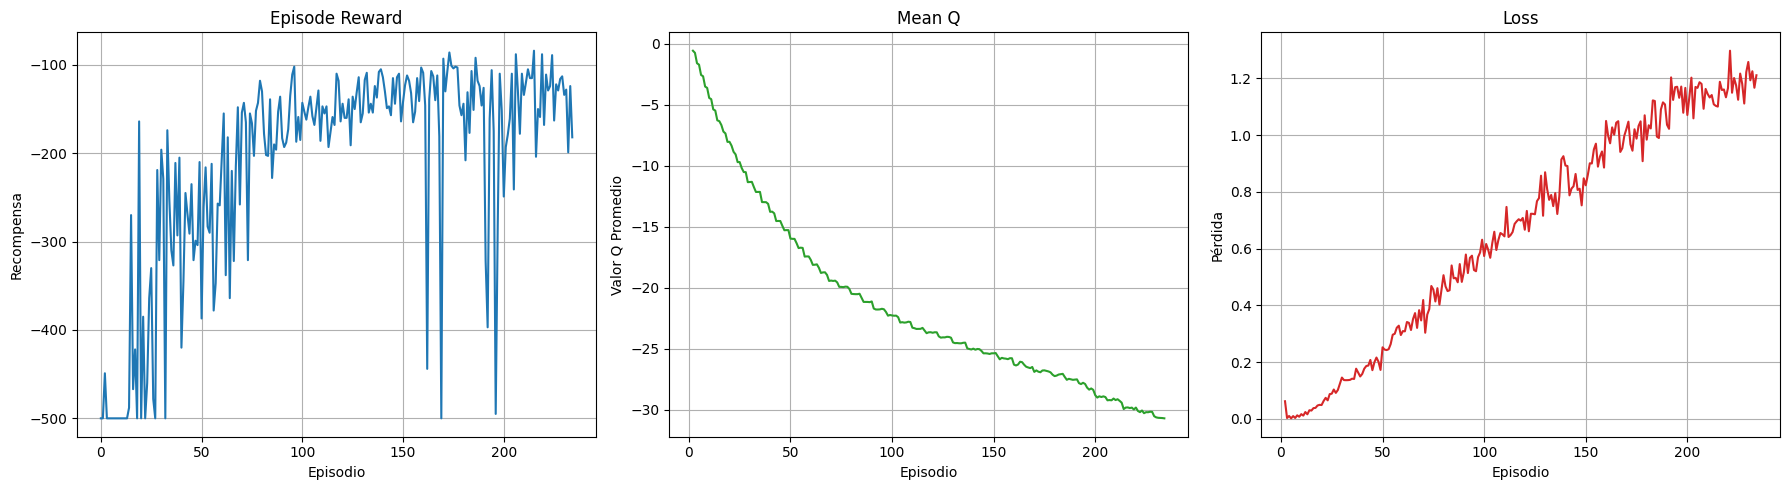

In [ ]:
# Cargar pesos entrenados v7
egreed_dqn_v7.load_weights('baseline_v7_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v7 = egreed_dqn_v7.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v7 = test_history_v7.history['episode_reward']

# Resultados
print("Recompensas en test (_v7):", episodic_rewards_v7)
print(f"Recompensa media: {np.mean(episodic_rewards_v7):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v7):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename_v7)

Se han realizado tres entrenamientos, en los que se ha mantenido la misma arquitectura de red y se han modificado únicamente los valores de exploración (epsilon_max = 0.8, epsilon_min = 0.02). Aunque el objetivo era favorecer una exploración más controlada y eficiente, los resultados obtenidos han sido dispares y no especialmente satisfactorios en términos de rendimiento general. En los tres intentos, el agente mostró cierta capacidad de aprendizaje, pero la estabilidad fue limitada y persistieron episodios con recompensas mínimas (-500), señal de fallos graves en la ejecución de la política aprendida. Aunque uno de los entrenamientos logró una recompensa media aceptable (-116.7), los otros se mantuvieron lejos de valores óptimos y con alta variabilidad. En conjunto, esta configuración no ha demostrado una mejora clara respecto a versiones anteriores, por lo que se decide mantener la versión anterior como referencia base.

Intento | Recompensa media | Desviación típica  
--------|------------------|-------------------  
1       | -250.00          | 90.70  
2       | -309.10          | 191.22  
3       | -116.70          | 44.85  

### Arquitectura de la red. Modelo final mejorado

Tras analizar los resultados obtenidos en los intentos anteriores, se ha decidido continuar con una nueva configuración, versión v11, que incorpora dos cambios clave. En primer lugar, se retoman los valores clásicos de la política de exploración, utilizando epsilon_max = 1.0 y epsilon_min = 0.05, para asegurar una exploración amplia en las primeras fases del entrenamiento y mantener un grado mínimo de aleatoriedad durante el proceso. En segundo lugar, se mejora la arquitectura del modelo, implementando una red más profunda compuesta por tres capas densas de 128, 128 y 64 neuronas respectivamente. Esta estructura busca dotar al agente de mayor capacidad de representación y mejorar su habilidad para aprender políticas más complejas y estables. Además, se han duplicado los pasos de entrenamiento a 100.000 y se ha reducido el intervalo de actualización del modelo objetivo (target_model_update = 250) para favorecer una adaptación más frecuente y precisa durante el aprendizaje. Esta combinación pretende lograr una mayor estabilidad y eficiencia en el rendimiento del agente.

In [ ]:
# Hiperparámetros
memory_limit_v11 = 20000
window_length_v11 = 1
max_eps_v11, min_eps_v11, test_eps_v11 = 1.0, 0.05, 0.01
steps_exploration_v11 = 45000
steps_warmup_v11 = 1000
gamma_v11 = 0.99
target_model_update_v11 = 250
train_interval_v11 = 1
learning_rate_v11 = 1e-3
nb_steps_v11 = 100000
batch_size_v11 = 128

# Modelo mejorado
model_v11 = tf.keras.models.Sequential()
model_v11.add(tf.keras.layers.Flatten(input_shape=(window_length_v11,) + env.observation_space.shape))
model_v11.add(tf.keras.layers.Dense(128, activation='relu'))
model_v11.add(tf.keras.layers.Dense(128, activation='relu'))
model_v11.add(tf.keras.layers.Dense(64, activation='relu'))
model_v11.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model_v11.summary()

# Memoria y política
memory_v11 = SequentialMemory(limit=memory_limit_v11, window_length=window_length_v11)
policy_v11 = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                 value_max=max_eps_v11, value_min=min_eps_v11,
                                 value_test=test_eps_v11, nb_steps=steps_exploration_v11)

# Agente
egreed_dqn_v11 = DQNAgent(model=model_v11, nb_actions=nb_actions,
                         memory=memory_v11, policy=policy_v11,
                         nb_steps_warmup=steps_warmup_v11, gamma=gamma_v11,
                         target_model_update=target_model_update_v11,
                         train_interval=train_interval_v11,
                         batch_size=batch_size_v11)

# Compilación
egreed_dqn_v11.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate_v11), metrics=['mae'])

# Entrenamiento
log_filename_v11 = 'dqn_v11_{}_log.json'.format(env_name)
callbacks_v11 = [FileLogger(log_filename_v11, interval=100)]
egreed_dqn_v11.fit(env, callbacks=callbacks_v11, nb_steps=nb_steps_v11, visualize=False, verbose=2)

# Guardar pesos
egreed_dqn_v11.save_weights('dqn_v11_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 6)                 0         
                                                                 
 dense_20 (Dense)            (None, 128)               896       
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 3)                 195       
                                                                 
Total params: 25,859
Trainable params: 25,859
Non-trainable params: 0
_________________________________________________________________
Training for 100000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 1.466s, episode steps: 500, steps per second: 341, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.000 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1000/100000: episode: 2, duration: 4.064s, episode steps: 500, steps per second: 123, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.990 [0.000, 2.000],  loss: 0.018437, mae: 0.938621, mean_q: -1.333004, mean_eps: 0.985750
  1500/100000: episode: 3, duration: 2.926s, episode steps: 500, steps per second: 171, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.070 [0.000, 2.000],  loss: 0.015878, mae: 2.273581, mean_q: -3.341995, mean_eps: 0.976260
  2000/100000: episode: 4, duration: 2.958s, episode steps: 500, steps per second: 169, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.952 [0.000, 2.000],  loss: 0.022635, mae: 3.609484, mean_q: -5.326663, mean_eps: 0.966760
  2500/100000: episode: 5, duration: 2.996s, episode steps: 500, steps per second: 167, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.012 [0.000, 2.000],  loss: 0.032052, mae: 4.890187, mean_q: -7

Testing for 10 episodes ...
Episode 1: reward: -63.000, steps: 64
Episode 2: reward: -63.000, steps: 64
Episode 3: reward: -63.000, steps: 64
Episode 4: reward: -69.000, steps: 70
Episode 5: reward: -62.000, steps: 63
Episode 6: reward: -69.000, steps: 70
Episode 7: reward: -69.000, steps: 70
Episode 8: reward: -62.000, steps: 63
Episode 9: reward: -63.000, steps: 64
Episode 10: reward: -78.000, steps: 79
 Recompensas en test : [-63.0, -63.0, -63.0, -69.0, -62.0, -69.0, -69.0, -62.0, -63.0, -78.0]
Recompensa media: -66.10
Desviación típica: 4.89


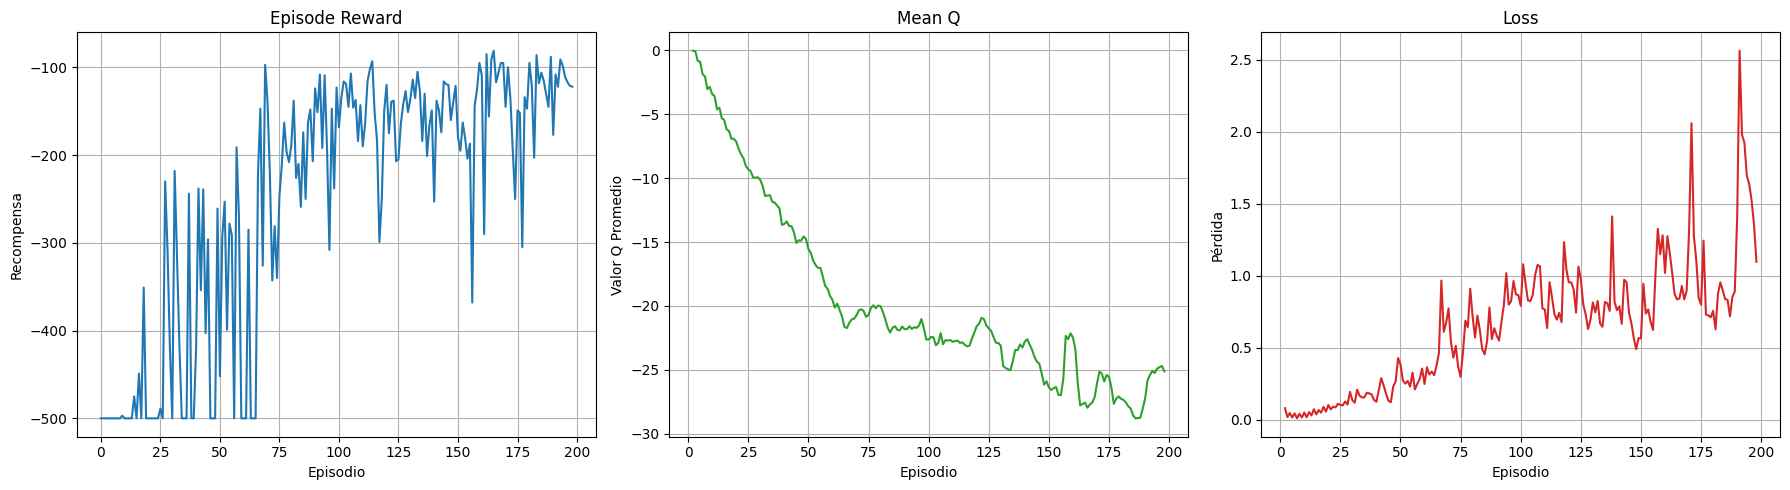

In [ ]:
# Cargar pesos entrenados
egreed_dqn_v11.load_weights('dqn_v11_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_v11 = egreed_dqn_v11.test(env, nb_episodes=10, visualize=False)
episodic_rewards_v11 = test_history_v11.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_v11)
print(f"Recompensa media: {np.mean(episodic_rewards_v11):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_v11):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

 Vemos que los resultados muestran que el agente es más estable, obteniendo una recompensa media de -66.10 y con poca variación entre episodios. Esto nos indica que los cambios han ayudado a que aprenda de forma más consistente. En el siguiente apartado, vamos a probar tres mejoras para el modelo base de DQN que hemos estado entrenando hasta ahora. Más adelante veremos cómo afectan los hiperparámetros a estos desarrollos de mejora, pero primero toca explicar y entender en qué consiste cada uno.

---
### 2. Investigar y presentar las diferencias de este agente con versiones más avanzadas.

Para poder entender bien las diferencias entre las variantes planteadas, es conveniente repasar primero en que consiste **DQN (ϵ-greedy)**.

## **DQN (ϵ-greedy)**
El Q-learning clásico aprende una tabla de valores $q(s, a)$, donde cada celda representa el valor esperado de tomar la acción $a$ en el estado $s$ y seguir una política voraz (greedy) desde entonces. Lo que pasa es que en dominios con numerosos estados, como el caso de los videojuegos, el método de la tabla es impracticable. Por eso, Deep Q-learning propone aproximar la función Q con una red neuronal que se entrena minimizando el error entre su salida y un valor objetivo que se calcula mediante la ecuación de Bellman:
$$L=(r+\gamma · \max_a q(s', a)-q(s, a))^2 $$

donde:  

|         |           |
|---------|-----------|
| $r$              | Recompensa inmediata de realizar $a$ en el estado $s$|
|$\gamma$          | Discount reward (conforme más cercano a 1, más importancia se le da a las recompensas futuras)|
|$\max_a q(s', a)$ | Mayor valor de $q$ estimado en el siguiente estado $s'$|
|$q(s, a)$         | Valor actual estimado tras realizar $a$ en el estado $s$|

Sin embargo, tal y como vimos en clase, la convergencia a la función $q$ óptima no se asegura ya que se trata de un proceso inestable con tendencia a quedarse atrapado en mínimo subóptimos. Por eso, se desarrollaron diferentes estrategias para intentar mejorar el algoritmo, entre las que destacan:


*   **Series temporales**: no es necesario trabajar con redes neuronales recurrentes (RNN), sino que se concatenan varios estados consecutivos y se introducen como entrada a la red neuronal para que el modelo pueda capturar la dinámica del entorno.
*   **Exploración**: con el fin de evitar el sobreajuste, se sigue una política ϵ-greedy que permite elegir acciones peores con una probabilidad=ϵ.
*   **Target network**: se usa una copia de una versión anterior de la red para calcular el valor objetivo, actualizándose periódicamente con los pesos de la red principal. Así, se reducen las oscilaciones del valor objetivo a lo largo del entrenamiento, es decir, se gana estabilidad. Cabe destacar que esta target network se usa para elegir las acciones y evaluarlas, no hay separación de procesos. Más adelante veremos que esta separación es la que presenta **Double DQN**.
*   **Experience replay**: se seleccionan muestras aleatorias de un buffer de experiencias pasadas para romper la correlación temporal entre datos consecutivos. Por esto mismo, DQN se clasifica como un algoritmo de aprendizaje por refuerzo **model-free off-policy**.
*   **Error clipping**: se suele utilizar la función de Huber para controlar los gradientes explosivos y así mejorar la estabilidad de los entrenamientos.

Aún con todo esto, DQN tiende a sobreestimar los valores de $q$ debido a que se usa la misma red para seleccionar y evaluar la mejor acción en el siguiente estado. Esta doble dependencia introduce un sesgo optimista que puede llevar a decisiones subóptimas, especialmente en entornos con recompensas ruidosas. Por este motivo surge ****Double DQN****.

# **Double DQN**
Tal y como explica Sarker (2019) [1], **Double DQN** trata de mitigar este problema desacoplando las fases de selección y evaluación, de forma que la acción se elige con la red que llaman "online", pero se evalua con la red "target". Así pues, con este nuevo enfoque:
1. Se evalúan todas las acciones posibles en el estado $s'$ con la red "online"
2. Se elige la mejor acción, la que nos da un valor estimado $q$ mayor, con la red "online".
3. El valor de la mejor acción se evalúa con la red "target".

La siguiente imagen [3] muestra claramente este proceso con ambas redes de forma gráfica para entenderlo bien:    

![Texto alternativo](https://images.theengineeringprojects.com/image/webp/2024/01/what-is-a-double-deep-q-network-3.png.webp?ssl=1)

En definitiva, aunque se sigue usando una red "target" ($θ'$) para calcular el valor objetivo, la acción que evalúa la elige la red "online" ($θ$). Se trata de un cambio mínimo con respecto la versión base DQN que reduce considerablemente la sobreestimación de $q$ y mejora la estabilidad del aprendizaje.

La función de pérdidas para **Double DQN** quedaría como:

$$L=(r+\gamma · q_{θ'}(s', \arg \max_a q_θ(s', a))-q_θ(s, a))^2 $$

donde:

|         |           |
|---------|-----------|
|$r$               | Recompensa inmediata de realizar $a$ en el estado $s$|
|$\gamma$          | Discount reward (conforme más cercano a 1, más importancia se le da a las recompensas futuras)|
|$\arg \max_a q_θ(s', a)$ | Acción óptima elegida en el siguiente estado $s'$ según la red "online" (O)|
|$q_{θ'}(s', \arg \max_a q_θ(s', a))$| Valor $q$ estimado de esa acción óptima en $s'$ usando la red "target" (T)|
|$q_θ(s, a)$         | Valor actual estimado tras realizar $a$ en el estado $s$ usando la red "online" (O)|

Se deja el pseudocódigo [4] de **Double DQN** a continuación, ya que servirá más adelante para llevar a cabo su implementación:  

![Texto alternativo](https://i.imgur.com/ClIMgeh.png)
(La imágen original ha sido editada porque la ' de la θ estaba situada incorrectamente, el artículo original (Hasselt et al., 2016) indica que **Double DQN** utiliza la red online para elegir y la red target para evaluar)  

Explicación del pseudocódigo:
1. Se inicializan:
  * La red "online", $Q_θ$
  * La red "target", $Q_{θ'}$
  * Un buffer de experiencias 𝒟
  * Un parámetro de interpolación τ para actualizar la red "target" suavemente.
2. Para cada iteración:  
    2.1. Para cada paso de interacción con el entorno:  
    * Se observa el estado actual $s_t$
    * Se elige una acción $a_t$ según la política exploratoria, como la ϵ-greedy.
    * Se realiza la acción $a_t$ y se obtiene la recompensa $r_t$ y el nuevo estado $s_{t+1}$
    * Se almacena la transición ($s_t$, $a_t$, $r_t$, $s_{t+1}$) en el buffer 𝒟.
    2.2. Para cada paso de actualización del agente (entrenamiento):
    * Se toma una muestra aleatoria $e_t$ = ($s_t$, $a_t$, $r_t$, $s_{t+1}$) del buffer 𝒟.
    * Se estima el valor objetivo $Q^\*(s, a)$ con **Double DQN** como:  
    $$ Q^\*(s, a) = r_t+\gamma · Q_{θ'}(s_{t+1}, \arg \max_a Q_{θ}(s_{t+1}, a)) $$
    * Se minimiza el error cuadrático entre el valor objetivo y el estimado:
    $$L = (Q^\*(s_t, a_t)-Q_\theta(s_t, a_t))^2$$
    * Se actualizan los pesos de la red "target" mediante el factor τ:  
    $$ θ'=τ·θ+(1-τ)·θ'$$

## ****Dueling DQN****
Una vez corregido el problema del sesgo optimista con **Double DQN**, ahora es momento de preguntarse si es necesario calcular $q(s, a)$ para cada acción en todos los estados. Hay veces en las que no todas las acciones tienen un impacto significativo en la calidad de una decisión, sino que solo nos interesa saber si el estado es bueno o malo independientemente de la acción que se ha elegido. Y esta reflexión da lugar al algoritmo de **Dueling DQN**, que introduce una nueva arquitectura de red diseñada para aprender de forma más eficiente en este tipo de situaciones.

Tal y como explica Sarker (2019) [1], Dueling QN se basa en dividir la red en dos ramas a partir de la representación latente, de forma que:


*   Una rama estima el valor del estado, $v(s)$, que indica lo bueno que es estar en el estado $s$, sin tener en cuenta la acción.
*   La otra rama estima la ventaja de cada acción, $A(s, a)$, para saber cuanto mejor o peor es realizar una acción $a$ en el estado $s$ en comparación con el resto.

![Texto alternativo](https://miro.medium.com/v2/resize:fit:577/1*KKR9bkqTIpisZzAadtu5-g.png)

Como se observa en el esquema, ambas ramas se combinan para construir el valor de $q(s, a)$ de la siguiente manera:
$$q(s, a)=v(s)+( A(s, a) - \frac{1}{|Α|}\sum_x A(s, a_x) )$$

Como se puede observar, en vez de simplemente sumar $v(s)$ y $A(s, a)$, se resta la media de las ventajas asociadas a todas las acciones posibles en el estado $s$. Esto se hace para resolver la ambigüedad que se da en la descomposición del valor $q(s, a)$, ya que sin esta normalización existirían  infinitas combinaciones posibles de $v(s)$ y $A(s, a)$ que podrían dar el mismo valor de $q(s, a)$, dificultando un aprendizaje estable. Al imponer que la media de las ventajas en un estado $s$ sea cero, se fuerza a que $v(s)$ represente de manera única el valor esperado del estado, mientras que $A(s, a)$
refleja únicamente el efecto relativo de cada acción respecto a la media.

Por tanto, la modificación que aporta **Dueling DQN** afecta al cálculo de $q(s, a)$, que ahora se calcula a través del valor del estado y la ventaja de las acciones, pero sigue conservando el mecanismo de **Double DQN** de utilizar una red "online" para seleccionar las acciones y otra "target" para evaluarlas. Por eso, la función de pérdidas es la misma, lo único que cambia el es cálculo de $q(s, a)$:  
$$L=(r+\gamma · q_{θ'}(s', \arg \max_a q_θ(s', a))-q_θ(s, a))^2 $$
siendo:
$$q(s, a)=v(s)+( A(s, a) - \bar{A}(s))$$

La arquitectura fue propuesta por Wang et al. (2016) [5], quienes demostraron que el uso de esta estructura mejoraba el rendimiento frente a **DQN** y **Double DQN** en diferentes tareas (dentro del benchmark de juegos Atari), especialmente cuando algunas acciones tenían un impacto insignificante y la calidad de la decisión dependía principalmente del estado.

Con respecto al pseudocódigo de **Dueling DQN**, es igual que el de **Double DQN** pero cambiando la fórmula con la que se obtiene $q(s, a)$:
![Texto alternativo](https://i.imgur.com/tjKk9H4.png)


## **Boltzmann Policy**
Aparte de los desarrollos de **Double DQN** (redcuir la sobreestimación de $q$) y **Dueling DQN** (mejorar la estimación del valor de cada acción), hay otra mejora orientada al proceso de exploración en el algoritmo de DQN, y esta es la política de **Boltzmann** [6], también conocida como *softmax* policy. A diferencia de la política ε-greedy, que selecciona una acción aleatoria con probabilidad ε y la mejor acción con probabilidad 1 – ε, Boltzmann distribuye la probabilidad de selección entre todas las acciones de forma proporcional a su valor estimado $q(s,a)$, haciendo que la exploración sea más significativa y más suave.

La probabilidad de seleccionar una acción $a$ en un estado $s$ se calcula como:  

$$ P(a \mid s) = \frac{e^{q(s, a)/\tau}}{\sum\limits_{a} e^{q(s, a)/\tau}}$$

donde τ es en este caso el parámetro de temperatura que regula el grado de aleatoriedad:
* Si τ→0, la política se vuelve casi determinista (greedy)
* Si τ→∞, todas las acciones tienen la misma probabilidad (aleatoriedad máxima)

Además, τ puede adaptarse dinámicamente a lo largo del entrenamiento. Al principio, la política prioriza la exploración probando muchas acciones distintas, pero con el tiempo se centra en explotar las que dan mejores recompensas.

Este enfoque tiene la ventaja de que acciones con valores de $q$ inferiores al máximo aún tienen una probabilidad razonable de ser elegidas, lo que puede venir bien en entornos ruidosos o con muchas acciones con valores similares.

Esta política se puede implementar directamente con librerías como BoltzmannQPolicy() en Keras-RL, tal y como hemos visto en los notebooks de clase. En el siguiente apartado veremos en detalle como aplicarla.

## Resumen comparativo

| Modelo         | Q-Function                              | Selección de acción                             | Evaluación de acción                           | Ventaja principal                             | Limitación principal                         |
|----------------|------------------------------------------|--------------------------------------------------|------------------------------------------------|------------------------------------------------|------------------------------------------------|
| **DQN**        | Una sola red                             | $ϵ$-greedy                              | Misma red                                      | Simple, método base                  | Sobreestima $q$, puede ser inestable         |
| **Double DQN** | Dos redes: online y target  |  $a^*=\arg\max_a q_{θ}(s', a)$<br> (elige acción)     | $q_{θ'}(s', a^*)$ (evalúa acción) | Reduce sobreestimación de $q$         | Manejo de dos redes                 |
| ****Dueling DQN****| $q(s, a) = v(s) + (A(s,a) - \bar{A}(s))$ | $ϵ$-greedy                              | Se combinan $v(s)$ y $A(s,a)$                  | Mejora la estimación del valor de cada acción | Arquitectura más compleja (dos ramas)     |
| **Boltzmann**  | Igual que DQN                            | $P(a|s) \propto e^{Q(s,a)/\tau}$<br>(softmax probabilístico) | Igual que DQN                                      | Exploración más suave  | Sensible al valor de $\tau$                  |




## Referencias
[1] Sarker, I. H. (2019). Foundations of Deep Reinforcement Learning: Theory and Practice in Python (Cap. 8). Springer. https://doi.org/10.1007/978-981-13-8285-7  

[2] Van Hasselt, H., Guez, A., & Silver, D. (2015). Deep reinforcement learning with double Q-learning. Proceedings of the AAAI Conference on Artificial Intelligence, 30(1), 2094–2100. https://doi.org/10.1609/aaai.v30i1.10295  

[3] The Engineering Projects. (2024, January). What is a Double Deep Q-Network? https://www.theengineeringprojects.com/2024/01/what-is-a-double-deep-q-network.html

[4] Yoon, C. (2019, July 30). Double Deep Q-Networks. Medium. https://medium.com/data-science/double-deep-q-networks-905dd8325412

[5] Wang, Z., Schaul, T., Hessel, M., Van Hasselt, H., Lanctot, M., & De Freitas, N. (2016). Dueling network architectures for deep reinforcement learning. Proceedings of the 33rd International Conference on Machine Learning (ICML), 48(1), 1995–2003 https://arxiv.org/pdf/1511.06581

[6] Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd ed.) (Cap. 2.7). MIT Press. https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf



---
### 3. Comparar, empleando keras-rl, el rendimiento de estos métodos más avanzados.

Para realizar la comparación de cada modelo, en primer lugar se lanzarán utilizando los hiperparámetros del modelo mejorado encontrado en el apartado 1. Después, se realizarán diversas pruebas con los hiperparámetros para intentar ajustarlos mejor al método avanzado concreto que se esté probando.

### Double DQN - Hiperparámetros versión base mejorada


In [ ]:
# Hiperparámetros
memory_limit = 20000
window_length = 1
max_eps, min_eps, test_eps = 1.0, 0.05, 0.01
steps_exploration = 45000
steps_warmup = 1000
gamma = 0.99
target_model_update = 250
train_interval = 1
learning_rate = 1e-3
nb_steps = 100000
batch_size = 128

# Construcción modelo
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model.summary()

# Memoria y policy
memory = SequentialMemory(limit=memory_limit, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                             value_max=max_eps, value_min=min_eps,
                             value_test=test_eps, nb_steps=steps_exploration)

# Creación agente Double DQN
dqn_double = DQNAgent(model=model, nb_actions=nb_actions,
                      memory=memory, policy=policy,
                      nb_steps_warmup=steps_warmup, gamma=gamma,
                      target_model_update=target_model_update,
                      train_interval=train_interval,
                      batch_size=batch_size,
                      enable_double_dqn=True)

# Compilación
dqn_double.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'dqn_double_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]

dqn_double.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos entrenados
dqn_double.save_weights('dqn_double_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 25,859
Trainable params: 25,859
Non-trainable params: 0
_________________________________________________________________
Training for 100000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 0.404s, episode steps: 500, steps per second: 1237, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.004 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/100000: episode: 2, duration: 0.358s, episode steps: 500, steps per second: 1397, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.996 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/100000: episode: 3, duration: 4.645s, episode steps: 500, steps per second: 108, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.048 [0.000, 2.000],  loss: 0.015689, mae: 0.995018, mean_q: -1.412776, mean_eps: 0.973611
  2000/100000: episode: 4, duration: 3.798s, episode steps: 500, steps per second: 132, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.032 [0.000, 2.000],  loss: 0.015260, mae: 2.376878, mean_q: -3.498697, mean_eps: 0.963066
  2500/100000: episode: 5, duration: 3.355s, episode steps: 500, steps per second: 149, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.092 [0.000, 2.000],  loss: 0.025278, mae: 3.748869, mean_q: -5.527180, mean_eps: 0.952511
  3000/100000: episode: 6, duration: 3.389s, episode steps: 500, steps per second: 148, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.994 [0.000, 2.000],  loss: 0.040992, mae: 5.194043, mean_q: -7

Testing for 10 episodes ...
Episode 1: reward: -63.000, steps: 64
Episode 2: reward: -79.000, steps: 80
Episode 3: reward: -64.000, steps: 65
Episode 4: reward: -66.000, steps: 67
Episode 5: reward: -64.000, steps: 65
Episode 6: reward: -64.000, steps: 65
Episode 7: reward: -63.000, steps: 64
Episode 8: reward: -67.000, steps: 68
Episode 9: reward: -88.000, steps: 89
Episode 10: reward: -63.000, steps: 64
 Recompensas en test : [-63.0, -79.0, -64.0, -66.0, -64.0, -64.0, -63.0, -67.0, -88.0, -63.0]
Recompensa media: -68.10
Desviación típica: 8.06


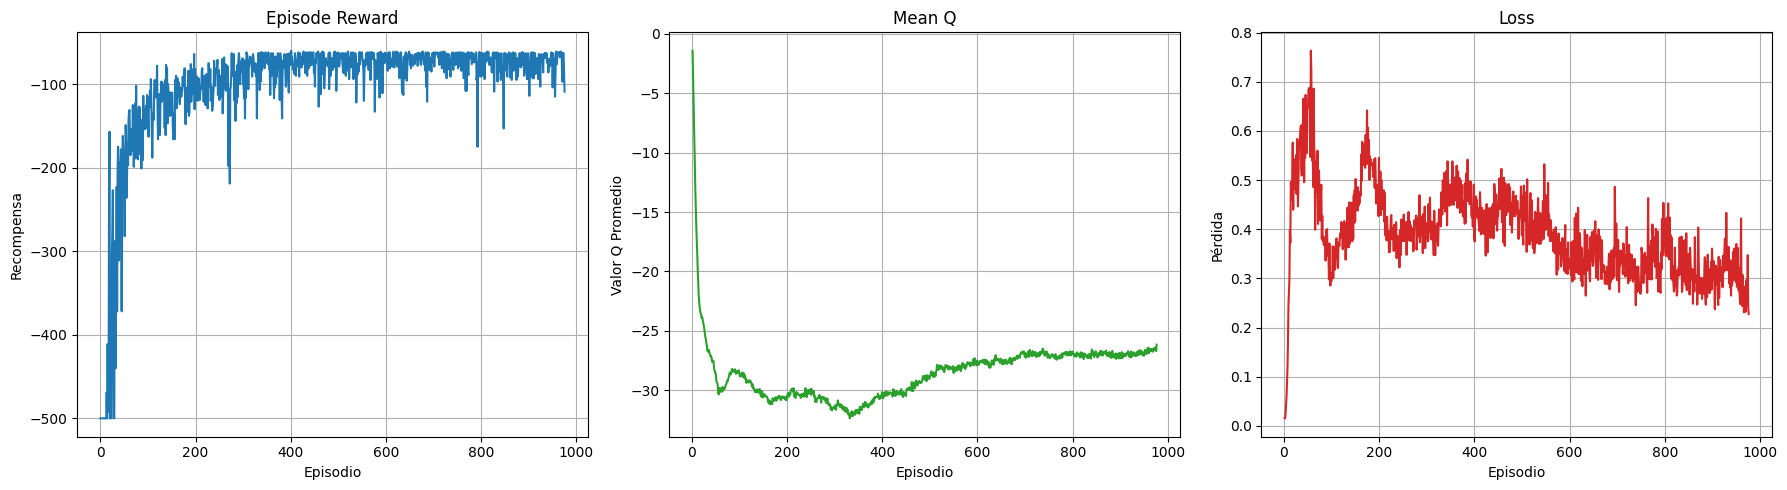

In [ ]:
# Cargar pesos entrenados
dqn_double.load_weights('dqn_double_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_double = dqn_double.test(env, nb_episodes=10, visualize=False)
episodic_rewards_double = test_history_double.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_double)
print(f"Recompensa media: {np.mean(episodic_rewards_double):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_double):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

Como se puede observar, el hecho de aplicar Double DQN no tiene un gran impacto sobre la recompensa media obtenida en el test, pero sí sobre las curvas de entrenamiento. En la curva de recompensas por episodio, podemos observar una mayor estabilidad, con recompensas menos variables una vez que se alcanzan valores altos. De igual forma, podemos ver como el valor Q también se ajusta mejor y de forma más estable.

En cuanto a la función de pérdida, aunque al principio la de Double DQN pueda ser más picuda, su estabilidad también mejora con respecto a la versión base. En cualquier caso y a pesar de que los resultados ya son buenos, vamos a intentar disminuir el hecho de que sigue siendo una curva de pérdida bastante ruidosa con la modificación de algunos hiperparámetros.

Por un lado, se procede a disminuir ligeramente el valor de learning_rate, para intentar suavizar el descenso del gradiente. Por otro lado, se aumenta el batch_size para intentar reducir la varianza del gradiente y aumentar la estabilidad de la pérdida.

### Double DQN - Hiperparámetros ajustados



In [ ]:
# Hiperparámetros
memory_limit = 20000
window_length = 1
max_eps, min_eps, test_eps = 1.0, 0.05, 0.01
steps_exploration = 45000
steps_warmup = 1000
gamma = 0.99
target_model_update = 250
train_interval = 1
learning_rate = 5e-4
nb_steps = 100000
batch_size = 256

# Construcción modelo
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model.summary()

# Memoria y policy
memory = SequentialMemory(limit=memory_limit, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                             value_max=max_eps, value_min=min_eps,
                             value_test=test_eps, nb_steps=steps_exploration)

# Creación agente Double DQN
dqn_double = DQNAgent(model=model, nb_actions=nb_actions,
                      memory=memory, policy=policy,
                      nb_steps_warmup=steps_warmup, gamma=gamma,
                      target_model_update=target_model_update,
                      train_interval=train_interval,
                      batch_size=batch_size,
                      enable_double_dqn=True)

# Compilación
dqn_double.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'dqn_double_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]

dqn_double.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos entrenados
dqn_double.save_weights('dqn_double_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 6)                 0         
                                                                 
 dense_10 (Dense)            (None, 128)               896       
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 25,859
Trainable params: 25,859
Non-trainable params: 0
_________________________________________________________________
Training for 100000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 0.500s, episode steps: 500, steps per second: 999, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.982 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/100000: episode: 2, duration: 0.366s, episode steps: 500, steps per second: 1368, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.974 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/100000: episode: 3, duration: 6.863s, episode steps: 500, steps per second:  73, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.006 [0.000, 2.000],  loss: 0.030437, mae: 1.067594, mean_q: -1.483993, mean_eps: 0.973611
  2000/100000: episode: 4, duration: 5.673s, episode steps: 500, steps per second:  88, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.962 [0.000, 2.000],  loss: 0.018467, mae: 2.469986, mean_q: -3.627543, mean_eps: 0.963066
  2500/100000: episode: 5, duration: 4.398s, episode steps: 500, steps per second: 114, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.982 [0.000, 2.000],  loss: 0.024673, mae: 3.801094, mean_q: -5.606691, mean_eps: 0.952511
  3000/100000: episode: 6, duration: 5.040s, episode steps: 500, steps per second:  99, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.948 [0.000, 2.000],  loss: 0.036606, mae: 5.107749, mean_q: -7

Testing for 10 episodes ...
Episode 1: reward: -64.000, steps: 65
Episode 2: reward: -64.000, steps: 65
Episode 3: reward: -74.000, steps: 75
Episode 4: reward: -65.000, steps: 66
Episode 5: reward: -64.000, steps: 65
Episode 6: reward: -63.000, steps: 64
Episode 7: reward: -63.000, steps: 64
Episode 8: reward: -64.000, steps: 65
Episode 9: reward: -63.000, steps: 64
Episode 10: reward: -64.000, steps: 65
 Recompensas en test : [-64.0, -64.0, -74.0, -65.0, -64.0, -63.0, -63.0, -64.0, -63.0, -64.0]
Recompensa media: -64.80
Desviación típica: 3.12


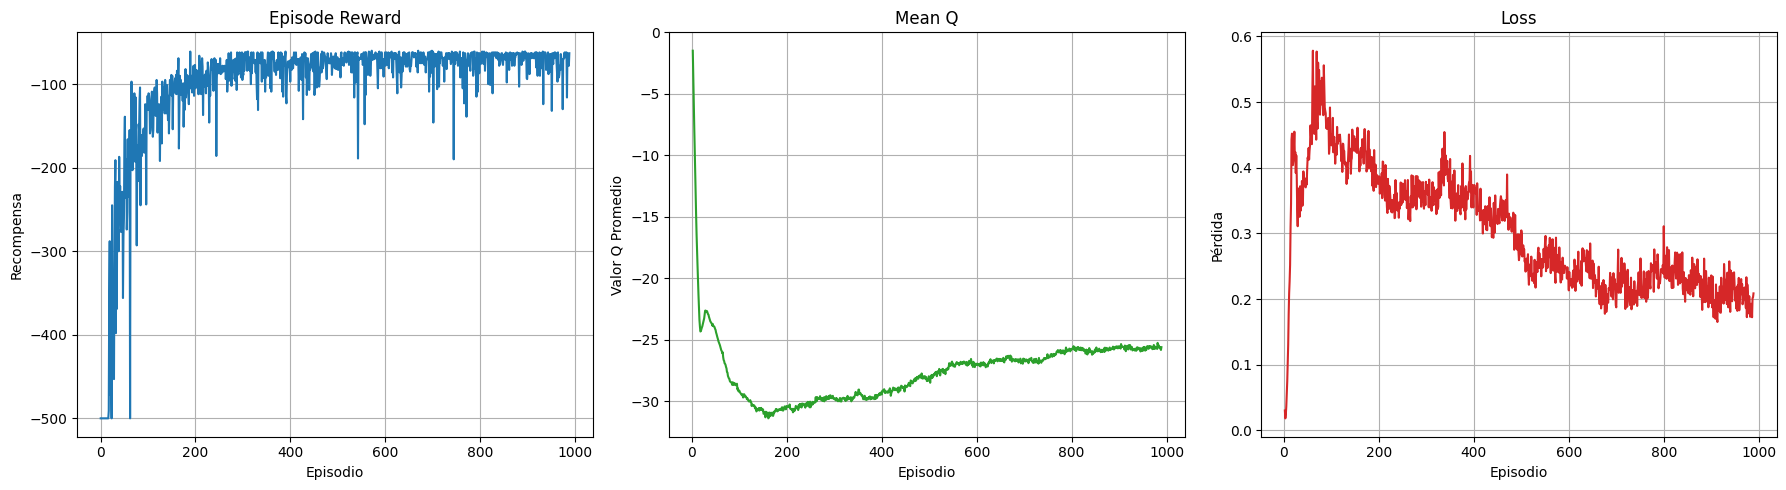

In [ ]:
# Cargar pesos entrenados
dqn_double.load_weights('dqn_double_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_double = dqn_double.test(env, nb_episodes=10, visualize=False)
episodic_rewards_double = test_history_double.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_double)
print(f"Recompensa media: {np.mean(episodic_rewards_double):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_double):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

Se observa que en general no han habido cambios sustanciales al ajustar los hiperparámetros para el modelo Double Q.

Las dos curvas (la de este entrenamiento y la del anterior) de recompensas por episodio durante el entrenamiento, alcanzan valores entorno a -80 a partir del episodio 200, punto en el que se alcanza la convergencia. En cuanto a la curva de Mean Q, parece que en esta ocasión aumenta algo más rápido y de forma un poco más estable.

Por lo que respecta a la función de pérdida, la cual estábamos intentando mejorar, se observa que sus valores han disminuído (la escala de la curva anterior alcanzaba un valor de 0.8, mientas que esta última está en torno a 0.6). Por tanto, aunque a simple vista parezca que las dos curvas son igual de 'ruidosas', en referencia a la escala se puede concluir que los valores de pérdida oscilan ligeramente menos en este último entrenamiento.

### Dueling DQN - Hiperparámetros versión base mejorada


In [ ]:
# Hiperparámetros
memory_limit = 20000
window_length = 1
max_eps, min_eps, test_eps = 1.0, 0.05, 0.01
steps_exploration = 45000
steps_warmup = 1000
gamma = 0.99
target_model_update = 250
train_interval = 1
learning_rate = 1e-3
nb_steps = 100000
batch_size = 128

# Modelo Dueling
input_layer = tf.keras.layers.Input(shape=(window_length,) + env.observation_space.shape)
x = tf.keras.layers.Flatten()(input_layer)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Valor del estado
v = tf.keras.layers.Dense(32, activation='relu')(x)
v = tf.keras.layers.Dense(1, activation='linear')(v)

# Ventaja de la acción
a = tf.keras.layers.Dense(32, activation='relu')(x)
a = tf.keras.layers.Dense(nb_actions, activation='linear')(a)

# Combinación final Q(s,a)
q_values = v + (a - tf.keras.backend.mean(a, axis=1, keepdims=True))
model = tf.keras.models.Model(inputs=input_layer, outputs=q_values)
model.summary()

# Memoria y política
memory = SequentialMemory(limit=memory_limit, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                             value_max=max_eps, value_min=min_eps,
                             value_test=test_eps, nb_steps=steps_exploration)

# Creación agente Dueling DQN
dqn_dueling = DQNAgent(model=model, nb_actions=nb_actions,
                       memory=memory, policy=policy,
                       nb_steps_warmup=steps_warmup, gamma=gamma,
                       target_model_update=target_model_update,
                       train_interval=train_interval,
                       batch_size=batch_size)

# Compilación
dqn_dueling.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'dqn_dueling_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]

dqn_dueling.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos entrenados
dqn_dueling.save_weights('dqn_dueling_{}_weights.h5f'.format(env_name), overwrite=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 6)]       0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 6)            0           ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           448         ['flatten_1[0][0]']              
                                                                                                  
 dense_5 (Dense)                (None, 64)           4160        ['dense_4[0][0]']                
                                                                                            

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 0.454s, episode steps: 500, steps per second: 1101, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.016 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/100000: episode: 2, duration: 0.409s, episode steps: 500, steps per second: 1223, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.032 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/100000: episode: 3, duration: 4.433s, episode steps: 500, steps per second: 113, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.998 [0.000, 2.000],  loss: 0.012026, mae: 0.961948, mean_q: -1.370351, mean_eps: 0.973611
  2000/100000: episode: 4, duration: 3.261s, episode steps: 500, steps per second: 153, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.984 [0.000, 2.000],  loss: 0.016268, mae: 2.298137, mean_q: -3.374113, mean_eps: 0.963066
  2500/100000: episode: 5, duration: 3.279s, episode steps: 500, steps per second: 152, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.034 [0.000, 2.000],  loss: 0.027144, mae: 3.619954, mean_q: -5.329982, mean_eps: 0.952511
  3000/100000: episode: 6, duration: 3.022s, episode steps: 500, steps per second: 165, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.032 [0.000, 2.000],  loss: 0.041927, mae: 4.950109, mean_q: -7

Testing for 10 episodes ...
Episode 1: reward: -63.000, steps: 64
Episode 2: reward: -64.000, steps: 65
Episode 3: reward: -85.000, steps: 86
Episode 4: reward: -64.000, steps: 65
Episode 5: reward: -63.000, steps: 64
Episode 6: reward: -63.000, steps: 64
Episode 7: reward: -84.000, steps: 85
Episode 8: reward: -63.000, steps: 64
Episode 9: reward: -63.000, steps: 64
Episode 10: reward: -62.000, steps: 63
 Recompensas en test : [-63.0, -64.0, -85.0, -64.0, -63.0, -63.0, -84.0, -63.0, -63.0, -62.0]
Recompensa media: -67.40
Desviación típica: 8.57


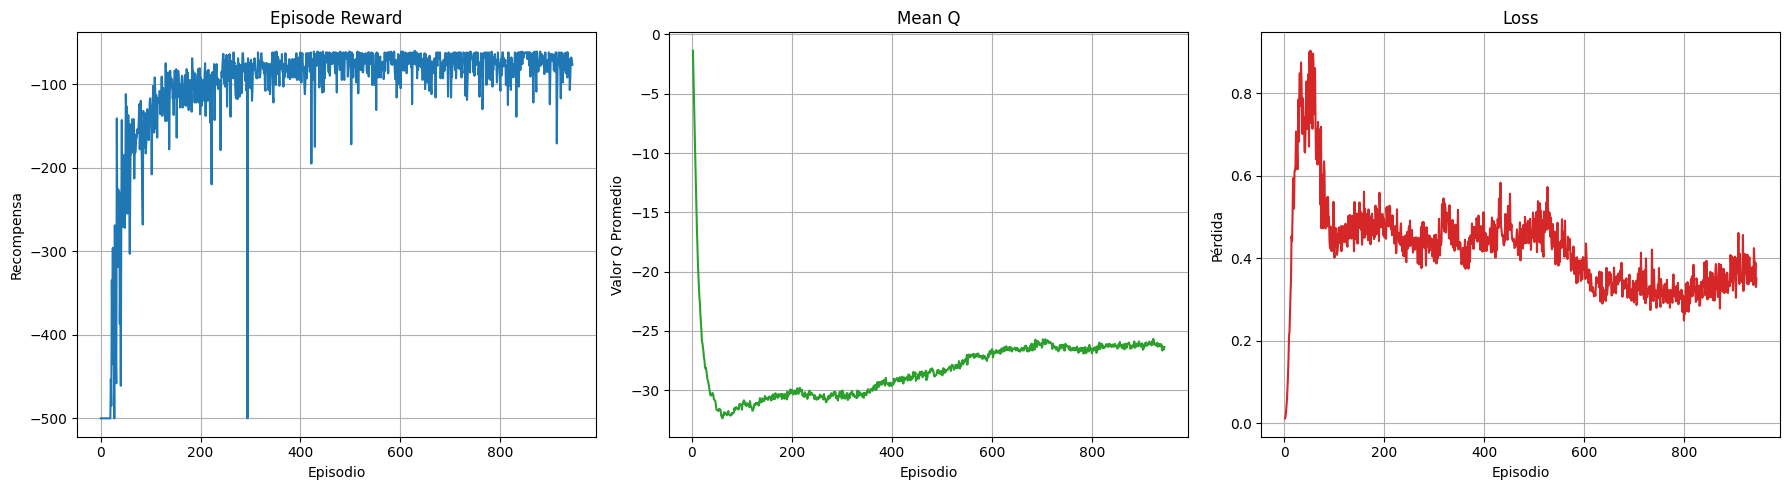

In [ ]:
# Cargar pesos entrenados
dqn_dueling.load_weights('dqn_dueling_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_dueling = dqn_dueling.test(env, nb_episodes=10, visualize=False)
episodic_rewards_dueling = test_history_dueling.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_dueling)
print(f"Recompensa media: {np.mean(episodic_rewards_dueling):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_dueling):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

De nuevo, aplicar un método avanzado como Dueling DQN no tiene un gran impacto sobre la recompensa media obtenida en el test, pero sí sobre las curvas de entrenamiento. La curva de recompensas por episodio también es mucho más estable que la del modelo base mejorado, aunque presenta algún pico en la primera mitad del entrenamiento. De igual forma, podemos ver como el valor Q también se ajusta de forma más estable y con valores similares a los obtenidos con Double DQN.

Volvemos a enfrentarnos al hecho de que el (corto) margen de mejora lo encontramos en la función de pérdida. Vamos a intentar disminuir la estabilidad de la curva modificanto el valor de learning_rate (disminuyéndolo un poco) y aumentando el batch size. Para estudiar también el efecto de otros hiperparámetros, se han realizado experimentos modificando los steps de exploración y el intervalo de entrenamiento.

### Dueling DQN - Hiperparámetros ajustados


In [ ]:
# Hiperparámetros
memory_limit = 20000
window_length = 1
max_eps, min_eps, test_eps = 1.0, 0.05, 0.01
steps_exploration = 75000
steps_warmup = 1000
gamma = 0.99
target_model_update = 250
train_interval = 4
learning_rate = 5e-3
nb_steps = 100000
batch_size = 256

# Modelo Dueling
input_layer = tf.keras.layers.Input(shape=(window_length,) + env.observation_space.shape)
x = tf.keras.layers.Flatten()(input_layer)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Valor del estado
v = tf.keras.layers.Dense(32, activation='relu')(x)
v = tf.keras.layers.Dense(1, activation='linear')(v)

# Ventaja de la acción
a = tf.keras.layers.Dense(32, activation='relu')(x)
a = tf.keras.layers.Dense(nb_actions, activation='linear')(a)

# Combinación final Q(s,a)
q_values = v + (a - tf.keras.backend.mean(a, axis=1, keepdims=True))
model = tf.keras.models.Model(inputs=input_layer, outputs=q_values)
model.summary()

# Memoria y política
memory = SequentialMemory(limit=memory_limit, window_length=window_length)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                             value_max=max_eps, value_min=min_eps,
                             value_test=test_eps, nb_steps=steps_exploration)

# Creación agente Dueling DQN
dqn_dueling = DQNAgent(model=model, nb_actions=nb_actions,
                       memory=memory, policy=policy,
                       nb_steps_warmup=steps_warmup, gamma=gamma,
                       target_model_update=target_model_update,
                       train_interval=train_interval,
                       batch_size=batch_size)

# Compilación
dqn_dueling.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'dqn_dueling_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]

dqn_dueling.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos entrenados
dqn_dueling.save_weights('dqn_dueling_{}_weights.h5f'.format(env_name), overwrite=True)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1, 6)]       0           []                               
                                                                                                  
 flatten_7 (Flatten)            (None, 6)            0           ['input_4[0][0]']                
                                                                                                  
 dense_34 (Dense)               (None, 64)           448         ['flatten_7[0][0]']              
                                                                                                  
 dense_35 (Dense)               (None, 64)           4160        ['dense_34[0][0]']               
                                                                                           

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 0.789s, episode steps: 500, steps per second: 634, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.010 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1000/100000: episode: 2, duration: 0.449s, episode steps: 500, steps per second: 1114, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.982 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/100000: episode: 3, duration: 2.902s, episode steps: 500, steps per second: 172, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.022 [0.000, 2.000],  loss: 0.027916, mae: 0.955373, mean_q: -1.323855, mean_eps: 0.984167
  2000/100000: episode: 4, duration: 1.560s, episode steps: 500, steps per second: 321, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.024 [0.000, 2.000],  loss: 0.048920, mae: 2.369145, mean_q: -3.426394, mean_eps: 0.977859
  2500/100000: episode: 5, duration: 1.939s, episode steps: 500, steps per second: 258, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.012 [0.000, 2.000],  loss: 0.066050, mae: 3.816381, mean_q: -5.589104, mean_eps: 0.971525
  3000/100000: episode: 6, duration: 1.553s, episode steps: 500, steps per second: 322, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.024 [0.000, 2.000],  loss: 0.084374, mae: 5.220839, mean_q: -7

Testing for 10 episodes ...
Episode 1: reward: -73.000, steps: 74
Episode 2: reward: -62.000, steps: 63
Episode 3: reward: -63.000, steps: 64
Episode 4: reward: -88.000, steps: 89
Episode 5: reward: -95.000, steps: 96
Episode 6: reward: -62.000, steps: 63
Episode 7: reward: -62.000, steps: 63
Episode 8: reward: -79.000, steps: 80
Episode 9: reward: -100.000, steps: 101
Episode 10: reward: -94.000, steps: 95
 Recompensas en test : [-73.0, -62.0, -63.0, -88.0, -95.0, -62.0, -62.0, -79.0, -100.0, -94.0]
Recompensa media: -77.80
Desviación típica: 14.65


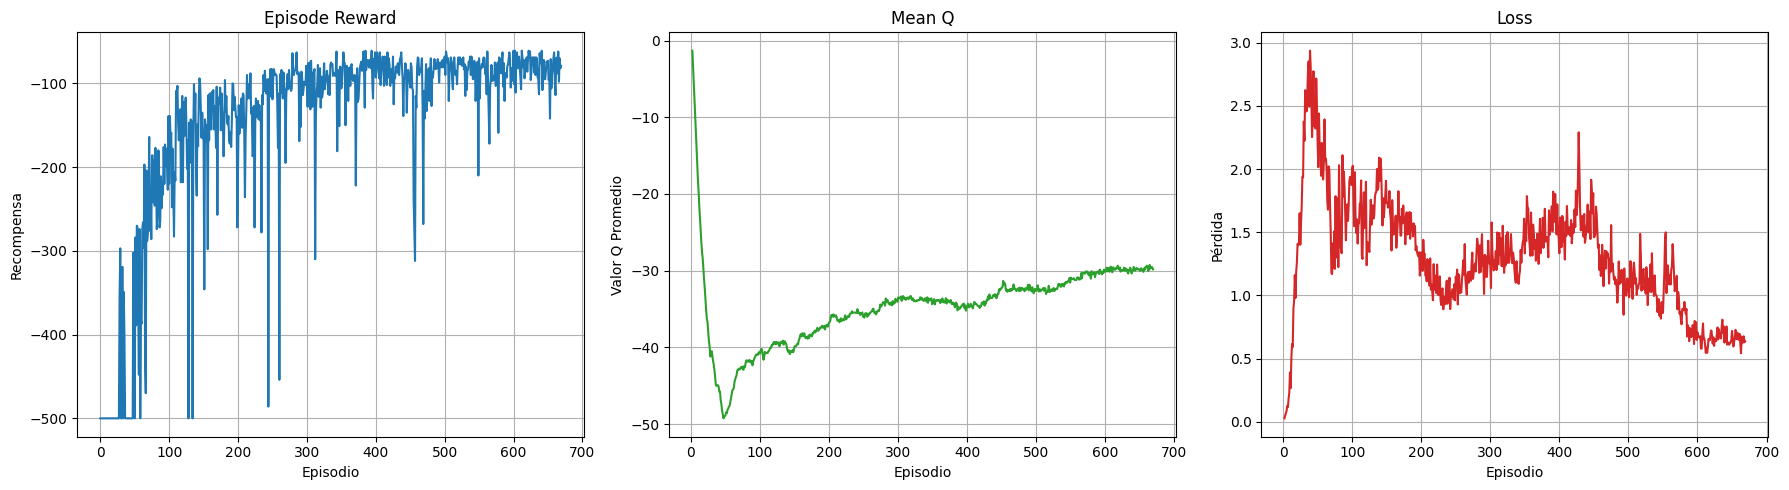

In [ ]:
# Cargar pesos entrenados
dqn_dueling.load_weights('dqn_dueling_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_dueling = dqn_dueling.test(env, nb_episodes=10, visualize=False)
episodic_rewards_dueling = test_history_dueling.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_dueling)
print(f"Recompensa media: {np.mean(episodic_rewards_dueling):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_dueling):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

Aunque los valores de test no se han visto, en general, perjudicados, podemos observar que las curvas de entrenamiento muestran peores resultados que el modelo de Dueling DQN entrenado con los hiperparámetros del modelo base mejorado.

El aumento de los steps de exploración y del intervalo de entrenamiento ha dado lugar a una curva de recompensas mucho más inestable. Además, la convergencia ha sido más lenta, pues se tardan más episodios en alzanzar valores que se mantengan alrededor de -80. La curva de pérdidas también se ha visto perjudicada, sin muestras de estabilizarse alrededor de ningún valor, y en general con valores más elevados que en el entrenamiento anterior. La curva de valores Q también parece empeorar, obteniendo valores ligeramente superiores (en valor absoluto).

### Boltzmann DQN - Hiperparámetros versión base mejorada


In [ ]:
# Hiperparámetros
memory_limit = 20000
window_length = 1
steps_warmup = 1000
gamma = 0.99
target_model_update = 250
train_interval = 1
learning_rate = 1e-3
nb_steps = 100000
batch_size = 128

# Modelo
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model.summary()

# Memoria y política Boltzmann
memory = SequentialMemory(limit=memory_limit, window_length=window_length)
policy = BoltzmannQPolicy()

# Creación agente Boltzmann DQN
dqn_boltzmann = DQNAgent(model=model, nb_actions=nb_actions,
                         memory=memory, policy=policy,
                         nb_steps_warmup=steps_warmup, gamma=gamma,
                         target_model_update=target_model_update,
                         train_interval=train_interval,
                         batch_size=batch_size)

# Compilación
dqn_boltzmann.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'dqn_boltzmann_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]

dqn_boltzmann.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos entrenados
dqn_boltzmann.save_weights('dqn_boltzmann_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 6)                 0         
                                                                 
 dense_14 (Dense)            (None, 128)               896       
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 25,859
Trainable params: 25,859
Non-trainable params: 0
_________________________________________________________________
Training for 100000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 0.561s, episode steps: 500, steps per second: 892, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.964 [0.000, 2.000],  loss: --, mae: --, mean_q: --
  1000/100000: episode: 2, duration: 0.410s, episode steps: 500, steps per second: 1219, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.958 [0.000, 2.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/100000: episode: 3, duration: 4.187s, episode steps: 500, steps per second: 119, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.988 [0.000, 2.000],  loss: 0.011265, mae: 0.885823, mean_q: -1.264270
  2000/100000: episode: 4, duration: 3.885s, episode steps: 500, steps per second: 129, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.016 [0.000, 2.000],  loss: 0.016049, mae: 2.254992, mean_q: -3.311183
  2500/100000: episode: 5, duration: 3.826s, episode steps: 500, steps per second: 131, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.032 [0.000, 2.000],  loss: 0.025459, mae: 3.648926, mean_q: -5.385007
  3000/100000: episode: 6, duration: 3.554s, episode steps: 500, steps per second: 141, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.078 [0.000, 2.000],  loss: 0.043703, mae: 5.025950, mean_q: -7.427025
  3500/100000: episode: 7, duration: 4.974s, episode

Testing for 10 episodes ...
Episode 1: reward: -500.000, steps: 500
Episode 2: reward: -84.000, steps: 85
Episode 3: reward: -85.000, steps: 86
Episode 4: reward: -211.000, steps: 212
Episode 5: reward: -86.000, steps: 87
Episode 6: reward: -500.000, steps: 500
Episode 7: reward: -62.000, steps: 63
Episode 8: reward: -71.000, steps: 72
Episode 9: reward: -500.000, steps: 500
Episode 10: reward: -500.000, steps: 500
 Recompensas en test : [-500.0, -84.0, -85.0, -211.0, -86.0, -500.0, -62.0, -71.0, -500.0, -500.0]
Recompensa media: -259.90
Desviación típica: 199.90


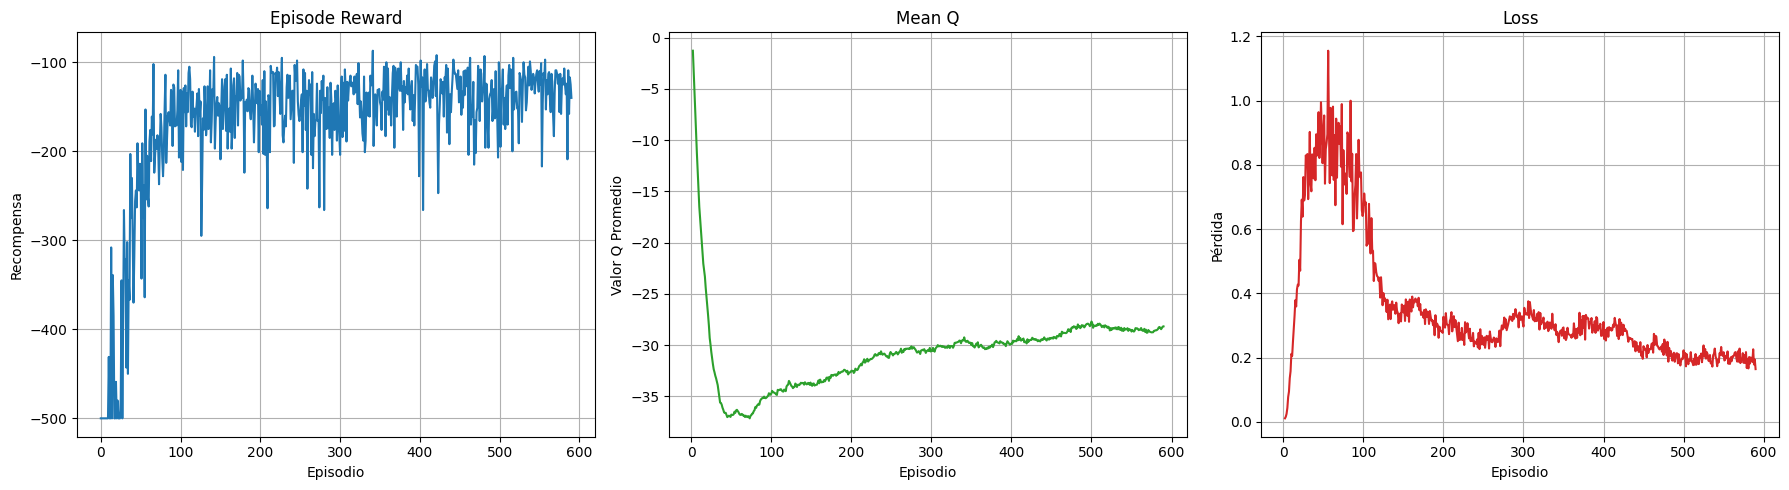

In [ ]:
# Cargar pesos entrenados
dqn_boltzmann.load_weights('dqn_boltzmann_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_boltzmann = dqn_boltzmann.test(env, nb_episodes=10, visualize=False)
episodic_rewards_boltzmann = test_history_boltzmann.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_boltzmann)
print(f"Recompensa media: {np.mean(episodic_rewards_boltzmann):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_boltzmann):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

En comparación con los otros dos métodos avanzados (Double y Dueling DQN), utilizar una política Boltzmann empeora los resultados.

En cuanto a los valores de recompensa de los episodios de test, se observan resultados mucho más inestables, con episodios donde incluso se alcanzan las recompensas mínimas.

Estos hechos no son tan evidentes cuando se observan las diferentes curvas de entrenamiento. Aunque si son menos estables que las obtenidas con los otros métodos avanzados, sus valores (como los de la curva de recompensas durante el entrenamiento) no son tan catastróficos como los que se muestran en test. Es decir, probablemente el modelo está teniendo problemas de generalización.

Para intentar resolver estos inconvenientes, se procede a modificar los hiperparámetros de target_model_update, para hacer actualizaciones del modelo objetivo un poco más espaciadas, y de batch_size, para hacer una mejor estimación del gradiente.

### Boltzmann DQN - Hiperparámetros ajustados


In [ ]:
# Hiperparámetros
memory_limit = 20000
window_length = 1
steps_warmup = 1000
gamma = 0.99
target_model_update = 150
train_interval = 1
learning_rate = 1e-3
nb_steps = 100000
batch_size = 256

# Modelo
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(nb_actions, activation='linear'))
model.summary()

# Memoria y política Boltzmann
memory = SequentialMemory(limit=memory_limit, window_length=window_length)
policy = BoltzmannQPolicy()

# Creación agente Boltzmann DQN
dqn_boltzmann = DQNAgent(model=model, nb_actions=nb_actions,
                         memory=memory, policy=policy,
                         nb_steps_warmup=steps_warmup, gamma=gamma,
                         target_model_update=target_model_update,
                         train_interval=train_interval,
                         batch_size=batch_size)

# Compilación
dqn_boltzmann.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=['mae'])

# Entrenamiento
log_filename = 'dqn_boltzmann_{}_log.json'.format(env_name)
callbacks = [FileLogger(log_filename, interval=100)]

dqn_boltzmann.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Guardar pesos entrenados
dqn_boltzmann.save_weights('dqn_boltzmann_{}_weights.h5f'.format(env_name), overwrite=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 6)                 0         
                                                                 
 dense_40 (Dense)            (None, 128)               896       
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 3)                 195       
                                                                 
Total params: 25,859
Trainable params: 25,859
Non-trainable params: 0
_________________________________________________________________
Training for 100000 steps ...


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   500/100000: episode: 1, duration: 0.862s, episode steps: 500, steps per second: 580, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.102 [0.000, 2.000],  loss: --, mae: --, mean_q: --
  1000/100000: episode: 2, duration: 0.464s, episode steps: 500, steps per second: 1078, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.080 [0.000, 2.000],  loss: --, mae: --, mean_q: --


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1500/100000: episode: 3, duration: 5.805s, episode steps: 500, steps per second:  86, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.030 [0.000, 2.000],  loss: 0.023224, mae: 1.785619, mean_q: -2.585652
  2000/100000: episode: 4, duration: 5.463s, episode steps: 500, steps per second:  92, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.068 [0.000, 2.000],  loss: 0.037557, mae: 4.010196, mean_q: -5.913847
  2500/100000: episode: 5, duration: 4.293s, episode steps: 500, steps per second: 116, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.000 [0.000, 2.000],  loss: 0.065036, mae: 5.928641, mean_q: -8.770139
  3000/100000: episode: 6, duration: 4.259s, episode steps: 500, steps per second: 117, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.992 [0.000, 2.000],  loss: 0.093022, mae: 7.714004, mean_q: -11.415572
  3500/100000: episode: 7, duration: 5.702s, episod

Testing for 10 episodes ...
Episode 1: reward: -63.000, steps: 64
Episode 2: reward: -62.000, steps: 63
Episode 3: reward: -62.000, steps: 63
Episode 4: reward: -63.000, steps: 64
Episode 5: reward: -94.000, steps: 95
Episode 6: reward: -69.000, steps: 70
Episode 7: reward: -63.000, steps: 64
Episode 8: reward: -62.000, steps: 63
Episode 9: reward: -70.000, steps: 71
Episode 10: reward: -62.000, steps: 63
 Recompensas en test : [-63.0, -62.0, -62.0, -63.0, -94.0, -69.0, -63.0, -62.0, -70.0, -62.0]
Recompensa media: -67.00
Desviación típica: 9.43


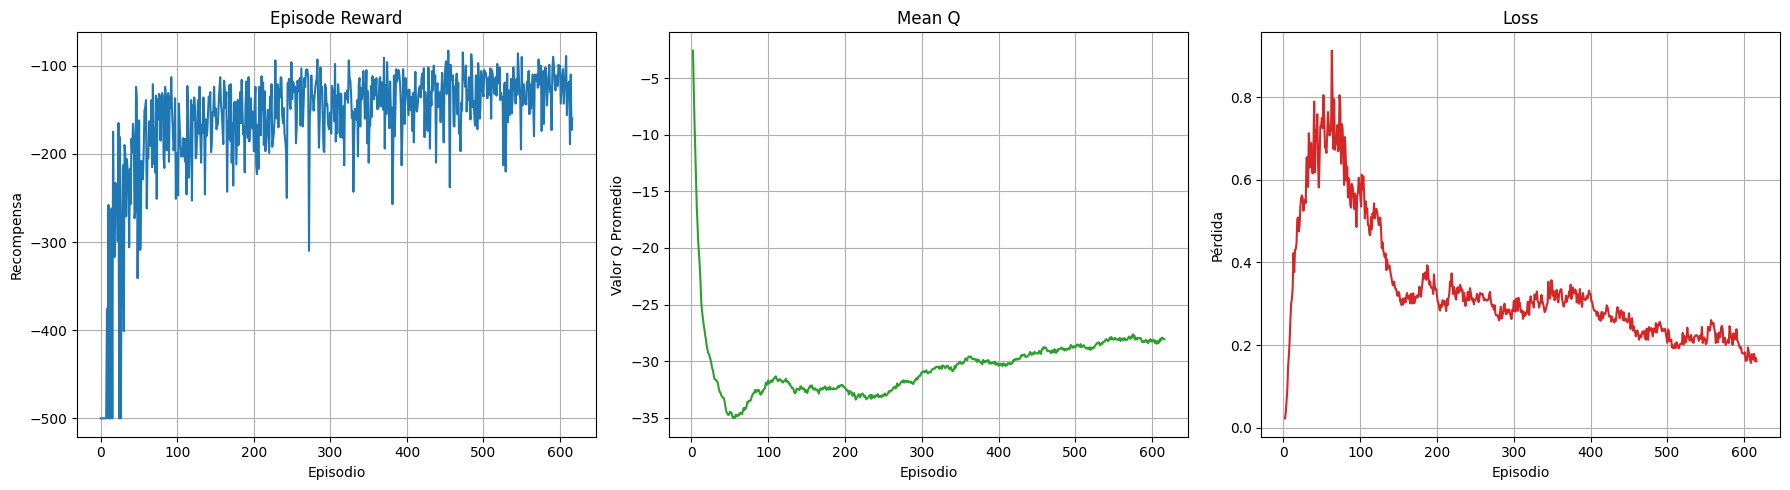

In [ ]:
# Cargar pesos entrenados
dqn_boltzmann.load_weights('dqn_boltzmann_{}_weights.h5f'.format(env_name))

# Evaluar el modelo en test
test_history_boltzmann = dqn_boltzmann.test(env, nb_episodes=10, visualize=False)
episodic_rewards_boltzmann = test_history_boltzmann.history['episode_reward']

# Resultados
print(" Recompensas en test :", episodic_rewards_boltzmann)
print(f"Recompensa media: {np.mean(episodic_rewards_boltzmann):.2f}")
print(f"Desviación típica: {np.std(episodic_rewards_boltzmann):.2f}")

# Visualizar curvas de entrenamiento
plot_training_metrics(log_filename)

Con los cambios realizados, se observa que los resultados de test vuelven a ser aceptables, obteniendo recompensas por debajo de -70 de media.

Si se observan las curvas, la de recompensas durante el entrenamiento sigue siendo la peor de entre todos los modelos avanzados, con valores que tardan en estabilizarse y que no superan las recompensas de -100.

No obstante, la curva de pérdidas mejora notablemente, pues los valores son menos 'ruidosos' (menos inestables, con menos variabilidad) y además se vuelven más bajos.

---
### 4. Exploración de hyper-parámetros. Discusión de los resultados.

Como se ha mostrado en el apartado *1. Mejorar la solución base*, se han realizado diversos entrenamientos modificando los hiperparámetros para alcanzar una solución estable y con recompensas mejoradas. Sin embargo, en dicho apartado se han mostrado solo aquellos entrenamientos que han supuesto una mejora sustancial en las recompensas de test y en las curvas de entrenamiento visualizadas. En realidad, se han realizado muchos más entrenamientos en los que se ha evaluado de forma independiente el efecto de algunos de los hiperparámetros más relevantes.

En este apartado, se procede en primer lugar a discutir los hallazgos encontrados en dichos entrenamientos. Después, se evaluarán las diferencias con respecto a los hiperparámetros empleados en el apartado 3 para los métodos **Bolzman Policy**, **Double DQN** y **Dueling DQN**.

#### 4.1. Discusión de hiperparámetros empleados durante la mejora del modelo base

Pasamos a estudiar el efecto de cada uno que hemos observado durante los entrenamientos.

- **window_length**

Uno de los cambios más determinantes para la mejora de las recompensas lo encontramos cuando se cambió el valor de ***window_length***. Acrobot se trata de un entorno totalmente determinista en el que cada observación contiene toda la información necesaria. Además, esta observación no se trata de una imagen (como en muchísimos otros entornos) donde pueda ser necesario observar imágenes de estados anteriores para determinar la acción a tomar. Sencillamente, en cada estado se tiene un vector de seis valores con los ángulos y velocidades angulares de los dos brazos, información suficiente para determinar la siguiente acción a tomar (aplicar un torque hacia atrás, hacia adelante, o no aplicarlo).

Es por estas razones que, cuando se disminuyó el valor de *window_length* a 1, las recompensas mejoraron notablemente con respecto al modelo base (la recompensa media en test pasó de alrededor de -300 a -100). Es decir, no es necesario un historial de los ángulos y velocidades de los pasos anteriores para tomar una acción. Aumentar este valor implica aumentar la dimensión de entrada y se añade así una complejidad innecesaria ya que el entorno se puede observar por completo en cada estado.

- **memory_limit**

Otro hiperparámetro determinante fue la ***memory_limit***. Primeramente probamos con valores más bajos, pero tal y como esperábamos, los resultados fueron pésimos. Con un valor aún más bajo de *memory_limit*, el *replay buffer* se llena más rápido y las experiencias antiguas se eliminan antes de poder aprender de ellas un número suficiente de veces. Esto nos llevaba a que no convergía a una política lo suficientemente buena, seguramente por posible sobreajuste a trayectorias que no eran eficientes.

No obstante, el aumento de la *memory_limit* junto con el resto de cambios mejoró notablemente los resultados. Esto se debe a que se tiene una mayor variabilidad de experiencias de las que aprender, con más diversidad de situaciones, lo que favorece la generalización del modelo y la estabilidad de los entrenamientos. Además, al aumentar el límite, las experiencias positivas (aquellas que se acercan a mejores recompensas) permanecen más tiempo en memoria, permitiendo el aprendizaje a partir de estas antes de ser eliminidas.

- **max_eps**, **min_eps**, **steps_exploration** y **test_eps**

En los experimentos realizados, la modificación de los hiperparámetros relacionados con épsilon y la política ϵ-greedy no contribuyeron significantemente a la mejora del modelo. Cuando se disminuyó el valor de *max_eps*, nos encontramos con que la mayoría de entrenamientos devolvían las recompensas mínimas y eran inestables. Esto se puede deber a que no se favorecía la exploración (poca aleatoriedad en la decisión de acciones a tomar) al principio del entrenamiento, lo que lleva a que la política quede atascada en sub-óptimos.

Por otro lado, cuando aumentamos en algunos entrenamientos el valor de *min_eps* observamos que la variabilidad de los valores de recompensa aumentaba durante el entrenamiento. Las razones por las que esto ocurre pueden deberse a que se toman más decisiones aleatorias incluso cuando ya ha terminado la fase de exploración, sin emplear en algunas ocasiones la política aprendida. Disminuir su valor tampoco nos aportó ninguna ventaja.

Por estas razones, la mejora de la solución base final mantiene los valores iniciales de *max_eps* y *min_eps*. En cualquier caso, el desempeño del agente con respecto a estos parámetros está directamente relacionado con los valores de *steps_exploration*, que determinarán cómo disminuye el valor de épsilon. Es aquí donde hemos encontrado alguna ventaja al emplear un número de pasos de exploración mayor. Aunque el agente tardaba algo más en estabilizarse y las recompensas mejoraban un poco más lento, observamos que las recompensas en test eran más robustas, posiblemente al haber explorado un espacio de posibilidades mayor. Además las curvas de *mean Q* evolucionaban de forma más suave.

En cuanto a los valores de *test_eps*, decidimos disminuirlo para hacer en test una evaluación más realista de la política aprendida, de forma que la probabilidad de elegir acciones aleatoriamente era menor.

- **gamma**

Puesto que en Acrobot no se tienen recompensas intermedias y la única recompensa útil es la del final del episodio (acabar en el menor número de pasos posible), el valor de gamma debe ser alto. Así, nos aseguramos de que el agente prevenga los movimientos que le harán 'ganar' (llegar a la altura requerida) dentro de muchos pasos. Es por ello que su valor se ha mantenido en 0.99.

De hecho, al hacer algunos experimentos donde se redujo este valor un poco (a 0.9) nos encontramos con que los entrenamientos se volvían inestables. Cuando conseguíamos que convergieran, las recompensas estaban cerca de los -300, pero en la mayoría de casos se obtenían recompensas mínimas y el entrenamiento era un fracaso.

- **target_model_update** (y train_interval)

Decidimos modificar este hiperparámetro para estudiar la relación entre la actualización de la red objetivo y el modelo principal. Típicamente, el modelo principal del agente se actualiza cada pocos pasos (por lo que decidimos dejar el valor de *train_interval* como en el modelo base). Cuando utilizamos valores muy bajos de *target_model_update*, más cercanos a los de *train_interval*, encontramos que los entrenamientos se volvían altamente inestables, debido a que la red objetivo cambiaba constantemente con el modelo.

Sin embargo, una disminución más moderada del *target_model_update* con respecto a su valor base mejoró los resultados. Esto puede deberse a que el entorno de Acrobot es sensible a la desincronización entre el modelo principal y la red objetivo. Como no hay recompensas intermedias, si el agente obtiene una buena recompensa en un episodio (y por consecuencia un mayor valor de Q), es necesario que esta no se propague (mediante *backpropagation*) en demasiados pasos. Disminuir levemente el valor de este hiperparámetro nos aportó una mayor rapidez de propagación de las informaciones buenas, acelerando la obtención de buenas políticas.

- **learning_rate**

Como Acrobot es un entorno sin recompensas intermedias y con muy pocas indicaciones de éxito al final de cada episodio exitoso, es bastante sensible al valor de la tasa de aprendizaje. Una de las pruebas que realizamos fue disminuir su valor (a 0.0005) buscando que fuera lo suficientemente bajo como para que no se produzca sobre-ajuste ni que los valores de Q oscilaran excesivamente. Sin embargo, los resultados no mejoraron especialmente. Esto puede ser debido a que el modelo aprendía tan despacio que no se propagaban las buenas experiencias con la suficiente 'intensidad'.

Por otro lado, también probamos a aumentar el valor (a 0.01), pero
para una red tan pequeña como la empleada, fue catastrófico. Los entrenamientos se volvieron inestables, devolviendo recompensas mínimas, y con grandes oscilaciones de los valores de *mean Q*.

El valor finalmente utilizado fue el del modelo base, de 0.001, ya que nos funcionó adecuadamente con otros cambios de hiperparámetros, como el *batch_size*.

- **batch_size**

El objetivo al modificar el valor del *batch_size* era encontrar un balance entre variabilidad y precisión. Con un batch más grande, se tiene una mayor variabilidad de transiciones, lo que lleva a promedios más representativos de la memoria y a un menor riesgo de *overfitting*. Sin embargo, la precisión puede verse comprometida ya que en Acrobot es difícil obtener experiencias valiosas, por lo que las pocas que se encuentran pueden verse poco reflejadas entre muchas experiencias con peores resultados. Por otro lado, un menor tamaño de lote favorece la exploración en entornos sencillos y redes pequeñas (como es el caso), pero tiende al sobre-ajuste.

Para encontrar el valor que nos ofrecía el equilibrio entre estos aspectos, nos fijamos en la evolución de las curvas de los valores medios de Q. Si tras muchas iteraciones no se producían mejoras en las curvas, se disminuía el valor de *batch_size*. Por el contrario, si se producían oscilaciones muy grandes del valor de *mean Q*, aumentábamos el tamaño de lote. Así, el valor final decidido fue de 128, el del baseline model.


#### 4.2. Discusión de la arquitectura de la red

Al comenzar la realización de este trabajo, la arquitectura de red neuronal de la solución base estaba formada por tres capas densas de 16 unidades cada una. Tras lanzar múltiples entrenamientos de esta solución base sin modificar los hiperparámetros, encontramos que los resultados eran altamente inestables: el agente no conseguía que la recompensa mejorase en la mayoría de ocasiones, con valores mínimos (-500) en todos los episodios de test, y los valores de Q tenían oscilaciones muy elevadas.

Tras exponer esta situación al profesor, llegamos a la conclusión de que con las últimas versiones de las librerías instaladas, la solución base era inestable debido a un problema de sobredimensionamiento de la red. Es por ello que, para la realización de los experimentos expuestos en este documento, la solución base pasó a estar formada por dos únicas capas densas, también de 16 unidades.

Esta simplificación permitió que los aprendizajes fueran más suaves y progresivos, se favoreció la generalización del modelo y se facilitó su convergencia. Así, durante los entrenamientos del modelo base y de los distintos experimentos sobre los hiperparámetros se obtuvieron resultados estables. Sin embargo, los mejores resultados que presentamos para el modelo del apartado 1 no solo vuelven a incluir una tercera capa, sino que aumentan el número de unidades empleados. ¿A qué se debe esto y cómo es posible?

Creemos que la clave es que los hiperparámetros finalmente seleccionados son más determinantes a la hora de estabilizar la dinámica de los entrenamientos. Ajustando hiperparámetros clave como *window_length*, *memory_limit*, *target_model_update* o *train_interval*, se han conseguido condiciones lo suficientemente estables como para poder hacer más amplia y profunda la red neuronal.

Decidimos experimentar con estos cambios para conseguir recompensas que superaran la barrera del -80, pero los entrenamientos solo fueron satisfactorios una vez realizamos los cambios de hiperparámetros explicados hasta ahora. La red final está compuesta por tres capas de 128, 128 y 64 unidades, lo que permitió que el modelo aprendiera representaciones más ricas del entorno.

Por tanto, es la combinación de una buena selección de parámetros y un buen diseño de arquitectura de red lo que permite alcanzar los resultados más óptimos. Las modificaciones en solo uno de estos ámbitos lleva a recompensas peores o a la inestabilidad de los entrenamientos. Así, la mejor arquitectura no es fija, y dependerá de en qué momento del desarrollo del modelo de aprendizaje nos encontremos y del grado de control que hayamos aplicado sobre el resto del sistema.

#### 4.3. Comparación de hiperparámetros entre los métodos avanzados

Por último, en esta sección se comparan los hiperparámetros de los tres métodos avanzados implementados: Double DQN, Dueling DQN y DQN con política Boltzmann. Aunque comparten gran parte de los hiperparámetros, como el gamma o el número total de pasos de entrenamiento (nb_steps), se han realizado ciertos ajustes puntuales en cada uno para estudiar y optimizar su comportamiento. Estos cambios responden tanto a consideraciones teóricas como a la observación empírica de las curvas de entrenamiento.

Una diferencia clave en los hiperparámetros de los tres modelos se encuentra en las políticas de exploración. Mientras que Double DQN y Dueling DQN siguen empleando una política epsilon-greedy como en la solución base, en el tercero se emplea una política de Boltzmann, lo que implica un cambio sustancial: no tiene sentido ajustar valores como epsilon o su tasa de decrecimiento, ya que esta política no depende de una probabilidad fija para explorar. En su lugar, se puede hacer variar el parámetro de temperatura (o tau). Sin embargo, se ha decidido mantener este en su valor por defecto, ya que en algunos experimentos en los que hemos probado a variarlo (aquí no mostrados), los resultados han sido bastante peores.

Otra gran diferencia entre los métodos avanzados es la arquitectura de red para el método Dueling DQN. En comparación a las arquitecturas empleadas para el resto de modelos, en este caso se ha optado por volver a una estructura más simple (con menos unidades por capa) para evitar un posible sobreajuste. Primero, se han definido dos capas densas de 64 unidades con activación ReLU, que actúan como base común para extraer representaciones relevantes del estado. Para la rama del valor del estado (V), se ha elegido una capa densa de 32 unidades seguida de una salida escalar lineal. Esta rama intenta estimar cuánto vale estar en un estado determinado, independientemente de la acción. En cuanto a la rama de ventaja de acción (A), también tiene una capa densa de 32 unidades y luego una salida con tantas neuronas como acciones (nb_actions), representando qué tan buena es cada acción en ese estado respecto a la media. La elección de estas capas y del número de unidades por cada una de ellas se ha realizado de forma empírica tras diversos entrenamientos.

Además de los cambios en la arquitectura de red y en el tipo de política de exploración, los tres modelos avanzados también difieren en algunos hiperparámetros clave que afectan al aprendizaje.

Uno de los parámetros ajustado fue train_interval, que tras los experimentos del apartado *1. Mejorar la solución base* se fijó en 1, y así se dejó en todos los modelos avanzados, permitiendo una actualización de la red en cada paso del entorno. Sin emargo, para el modelo de Dueling DQN, se experimentó volviéndo a situar su valor en 4, buscando permitr que el modelo aprenda más rápidamente de nuevas experiencias. También se ha probó a aumentar los steps_exploration, pero ninguno de estos cambios pareció proporcionar ninguna mejora sustancial

Otro de los parámetros modificados fue target_model_update, que se redujo de 250 a 150 en el modelo de Boltzmann. Este valor define cada cuántos pasos se actualiza la red objetivo, y reducirlo mejora la sincronización entre la red online y la target, lo que en algunas situaciones se traduce en una mayor estabilidad del entrenamiento, necesario para este modelo tras los resultados inciales obtenidos con él.

También cabe destacar que en los modelos de Double y Dueling DQN ha sido necesario disminuir el learning_rate y aumentar el batch_size para mejorar ligeramente la estabilidad de los entrenamientos.

---
### 5. Conclusiones y discusión

Este trabajo ha mostrado la complejidad de entrenar agentes de aprendizaje por refuerzo en entornos como Acrobot-v1, donde pequeñas decisiones en la arquitectura o en los hiperparámetros pueden tener un impacto significativo en la estabilidad y eficacia del entrenamiento. A lo largo del proyecto ha demostrado que no existen soluciones universales, sino que el éxito depende de un ajuste fino y coherente entre todos los componentes del sistema.

En una primera fase, la simplificación de la arquitectura del modelo base (de tres a dos capas de 16 neuronas) permitió corregir problemas de inestabilidad graves, debidos a un sobredimensionamiento de la red combinado con una mala configuración inicial de los hiperparámetros. Esta decisión no solo estabilizó el entrenamiento, sino que permitió realizar análisis más controlados sobre el efecto de cada parámetro posteriormente, asentando las bases para rediseñar una arquitectura más profunda y efectiva en el modelo final.

Uno de los descubrimientos más relevantes fue que parámetros como train_interval y memory_limit, que por separado no ofrecían mejoras claras, sí resultaron efectivos cuando se ajustaron de forma conjunta. Entrenar la red con mayor frecuencia (train_interval = 1) permite al agente adaptarse más rápidamente, pero también requiere una memoria más amplia (memory_limit = 20000) para disponer de suficientes experiencias variadas. Esto es un buen ejemplo de cómo un parámetro solo puede revelar su utilidad en el contexto adecuado.

La implementación de agentes avanzados como Double DQN, Dueling DQN y el uso de una política Boltzmann permitió explorar mejoras sobre el modelo base, sobre todo en cuanto a estabilidad. Cada modelo requirió ajustes específicos en arquitectura, políticas de exploración o sincronización de redes (por ejemplo, reduciendo target_model_update en el modelo Boltzmann), y aportó matices sobre cómo mejorar el rendimiento y la estabilidad del agente.

En resumen, no hay un modelo mejor en todo. Double DQN fue el más fácil de ajustar y el más estable. Dueling DQN puede ser útil si se controla bien la arquitectura. Y Boltzmann es una opción interesante para explorar mejor, pero en nuestro caso necesita una configuración más cuidadosa para funcionar mejor.